<span style="font-family: Open Sans; font-weight: 800; font-size: 40px; font-style: normal; text-align:center;">

Especialización Inteligecia Artificial - CEIA

</span>

<span style="font-family: Open Sans; font-weight: 700; font-size: 30px; font-style: normal; text-align:center;">

Aprendizaje de Máquinas

Trabajo práctico integrador

</span>

<span style="font-family: Open Sans; font-weight: 400; font-size: 20px; font-style: normal;">

<u>Autores</u>:
- Karen Raczkowski @raczki
- Juan Ignacio Ribet @Juaniribet
- Martín Caceres
- FS @BenjaSar

</span>

## Tabla de contenido
<a id='volver'></a>
----

1. [Carga del dataSet](#Carga-del-data-set)<br>
1.1 [Verificamos si algún  color solo está  presente en una clase](#Verificamos-si-algún-color-solo-está-presente-en-una-clase)<br>
1.2 [Verificamos si algún  material solo está  presente en una clase](#Verificamos-si-algún-material-solo-está-presente-en-una-clase)<br>
1.3 [Balance de clases](#Verificar-el-balance-de-clases)<br>
2. [Función evaluar](#Creamos-la-función-'evaluar')<br>
3. [Split Data Set](#Separamos-el-dataset)<br> 
4. Modelos<br>
4.1 [Logistic Regression CV](#LogisticRegressionCV)<br>
4.2 [XGB Classifier](#XGB-Classifier)<br>
4.3 [Logistic Regression with ROS](#Logistic-Regression-with-ROS)<br>
4.4 [SMOTE](#SMOTE)<br>
4.5 [Cat Boost Classifier](#CatBoostClassifier)<br>
4.6 [RandomForestClassifier](#RandomForestClassifier)<br>
4.7 [Bagging - Tree Classifier](#Bagging)<br>
5. [Comparacion de los modelos](#Comparacion-de-los-modelos)<br>
6. [Auto ML](#Auto-ML-:-PYCARET) <br>
7. [Conclusiones](#concluciones) <br>


In [47]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier


#Import to balance data
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

#Support Vector Machine method
from sklearn import svm

#Auto ML - Pycaret
import mlflow
from pycaret.classification import *
from pycaret.datasets import get_data

### Carga del data set

In [3]:
#carga del data set
data = pd.read_csv("./data/df_encoded.csv")
# Cambio nombre de columna themes 
data.rename(columns={'0': 'themes'}, inplace=True)
# Muevo themes (target) a la primera columna
cols = data.columns.tolist()
cols = [cols[-1]] + cols[:-1]
data = data[cols]
data.head()

themes  quantity_part  negro  gris    blanco  gris_2      rojo      azul  \
0       7             43    0.0   0.0  0.395349     0.0  0.302326  0.023256   
1       7              3    0.0   0.0  1.000000     0.0  0.000000  0.000000   
2       2             18    0.0   0.0  0.111111     0.0  0.388889  0.277778   
3       2              7    0.0   0.0  0.285714     0.0  0.142857  0.285714   
4       2             29    0.0   0.0  0.034483     0.0  0.379310  0.310345   

   amarillo  beige  ...  Tiles  Tiles Round and Curved  Tiles Special  Tools  \
0  0.093023    0.0  ...    0.0                     0.0            0.0    0.0   
1  0.000000    0.0  ...    0.0                     0.0            0.0    0.0   
2  0.222222    0.0  ...    0.0                     0.0            0.0    0.0   
3  0.142857    0.0  ...    0.0                     0.0            0.0    0.0   
4  0.275862    0.0  ...    0.0                     0.0            0.0    0.0   

   Transportation - Land  Transportation - Sea and Air  Tubes and Hoses  \
0                    0.0                           0.0              0.0   
1                    0.0                           0.0              0.0   
2                    0.0                           0.0              0.0   
3                    0.0                           0.0              0.0   
4                    0.0                           0.0              0.0   

   Wheels and Tyres  Windows and Doors  Windscreens and Fuselage  
0          0.511628                0.0                       0.0  
1          0.000000                0.0                       0.0  
2          0.000000                0.0                       0.0  
3          0.000000                0.0                       0.0  
4          0.000000                0.0                       0.0  

[5 rows x 80 columns]

In [4]:
#Nombre de las clases (tematicas de Lego)
clases = {'City': 0, 'Creator': 1, 'Duplo': 2, 'Educational and Dacta': 3, 'Friends': 4, 'Ninjago': 5, 'Star Wars': 6, 'Technic': 7, 'Town': 8, 'Universal Building Set': 9}
inv_clases = {v: k for k, v in clases.items()}
clases_list = list(clases.keys())

In [5]:
print(data.describe())

            themes  quantity_part        negro         gris       blanco  \
count  6732.000000    6732.000000  6732.000000  6732.000000  6732.000000   
mean      4.240790     232.687760     0.170670     0.080029     0.113409   
std       2.796274     458.384963     0.194104     0.132318     0.156090   
min       0.000000       1.000000     0.000000     0.000000     0.000000   
25%       2.000000      25.000000     0.015370     0.000000     0.000000   
50%       4.000000      74.000000     0.121951     0.000000     0.047619   
75%       7.000000     252.000000     0.250000     0.125000     0.185760   
max       9.000000    7663.000000     1.000000     1.000000     1.000000   

            gris_2         rojo         azul     amarillo        beige  ...  \
count  6732.000000  6732.000000  6732.000000  6732.000000  6732.000000  ...   
mean      0.056853     0.119167     0.064037     0.088573     0.017913  ...   
std       0.111552     0.154378     0.111766     0.133566     0.054816  ...   

In [6]:
# Describe agrupado por lego theme
grouped_df = data.groupby('themes').describe()
grouped_df = grouped_df.rename(index=inv_clases)
print(grouped_df)

                       quantity_part                                      \
                               count        mean         std  min    25%   
themes                                                                     
City                           739.0  241.136671  268.437351  1.0  38.00   
Creator                        493.0  421.316430  677.073393  1.0  62.00   
Duplo                         1233.0   36.351987   38.204882  1.0  10.00   
Educational and Dacta          573.0  218.022688  440.073859  1.0  24.00   
Friends                        530.0  232.758491  296.843594  1.0  36.00   
Ninjago                        512.0  267.835938  562.005001  1.0  11.00   
Star Wars                      832.0  397.959135  705.573794  1.0  55.00   
Technic                        772.0  350.419689  574.583738  1.0  39.75   
Town                           637.0  125.671900  164.090453  2.0  26.00   
Universal Building Set         411.0  166.965937  227.600535  1.0  14.50   

           

## Verificamos si algún color solo está presente en una clase

[inicio](#Tabla-de-contenido)

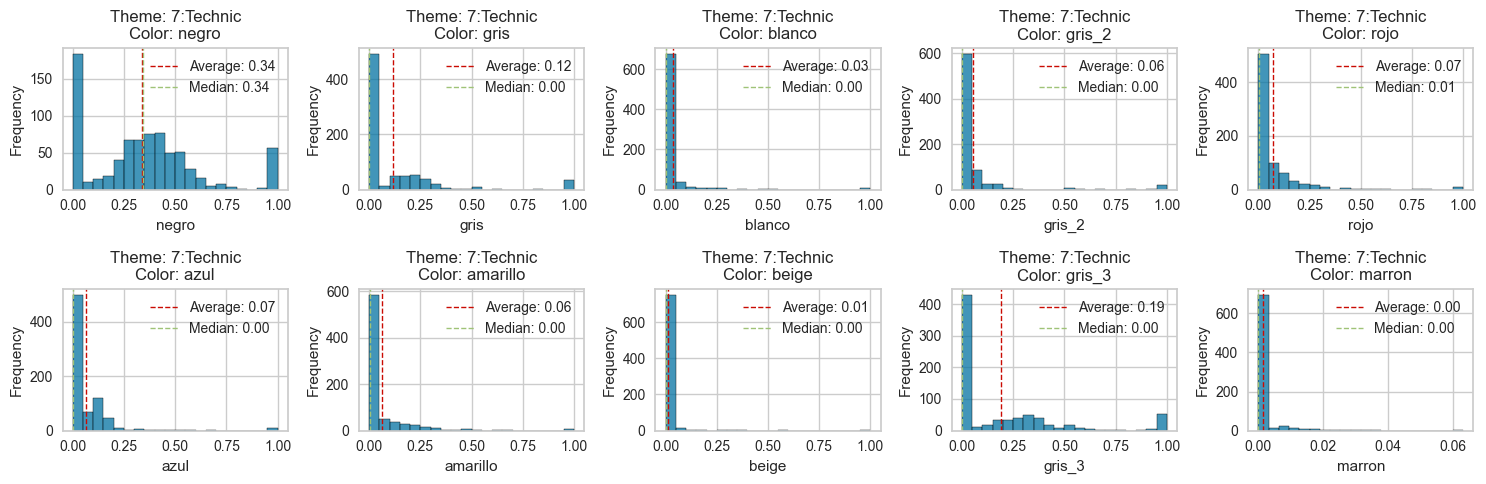

Descriptive Metrics for Theme 7:
            negro        gris      blanco      gris_2        rojo        azul  \
count  772.000000  772.000000  772.000000  772.000000  772.000000  772.000000   
mean     0.340176    0.117138    0.034376    0.055548    0.073240    0.065462   
std      0.273709    0.224572    0.122414    0.169555    0.153793    0.140851   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.099306    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.340580    0.000000    0.000000    0.000000    0.005306    0.000000   
75%      0.471627    0.181385    0.015891    0.041404    0.084571    0.106786   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         amarillo       beige      gris_3      marron  
count  772.000000  772.000000  772.000000  772.000000  
mean     0.060553    0.014310    0.190520    0.001412  
std      0.137798    0.079085    0.283966    0.005085  
min      0.00

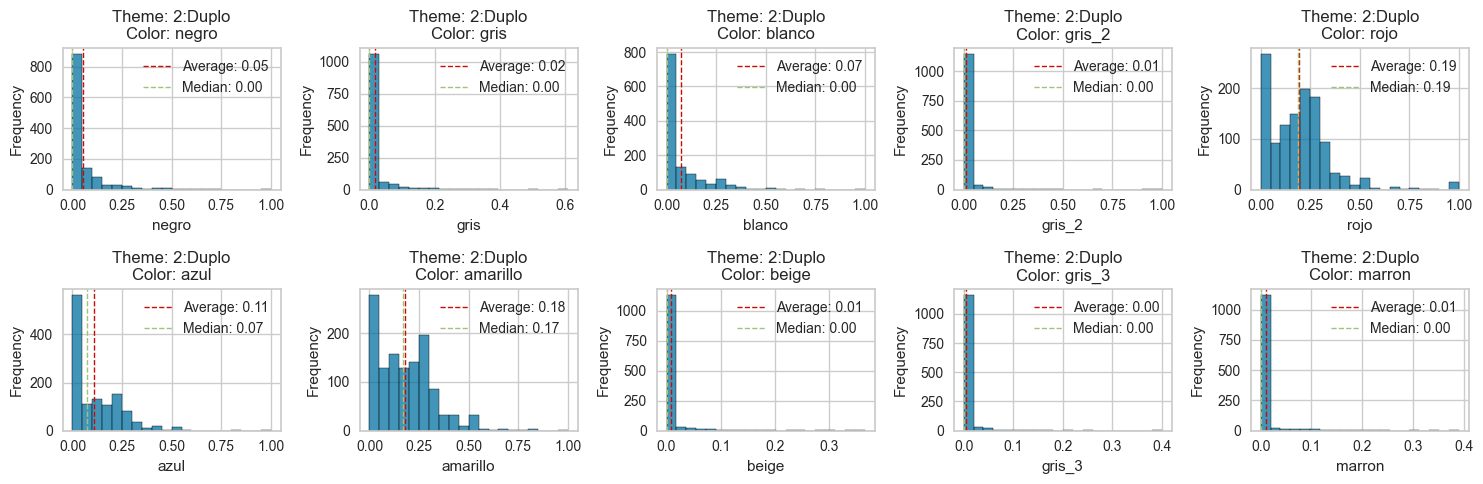

Descriptive Metrics for Theme 2:
             negro         gris       blanco       gris_2         rojo  \
count  1233.000000  1233.000000  1233.000000  1233.000000  1233.000000   
mean      0.052828     0.017037     0.073753     0.014312     0.192632   
std       0.111997     0.052822     0.125967     0.072828     0.163720   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.071429   
50%       0.000000     0.000000     0.000000     0.000000     0.190000   
75%       0.066667     0.000000     0.100000     0.000000     0.262712   
max       1.000000     0.608696     1.000000     1.000000     1.000000   

              azul     amarillo        beige       gris_3       marron  
count  1233.000000  1233.000000  1233.000000  1233.000000  1233.000000  
mean      0.111020     0.179298     0.007779     0.004849     0.010493  
std       0.126758     0.144618     0.033204     0.024310     0.041110  
min     

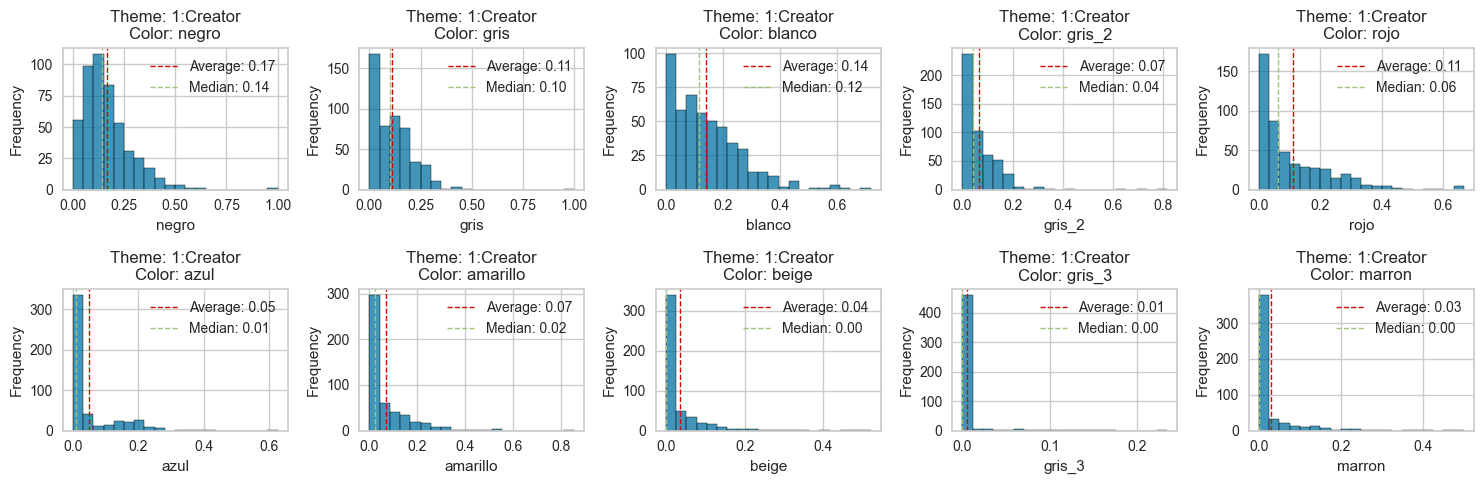

Descriptive Metrics for Theme 1:
            negro        gris      blanco      gris_2        rojo        azul  \
count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
mean     0.165918    0.110357    0.140711    0.065675    0.110185    0.050407   
std      0.116445    0.103029    0.119527    0.083217    0.123075    0.082275   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.088511    0.019206    0.051852    0.000000    0.021127    0.000000   
50%      0.141667    0.100000    0.117647    0.044218    0.062657    0.008929   
75%      0.219388    0.167291    0.202512    0.098765    0.176000    0.055276   
max      1.000000    1.000000    0.717949    0.815568    0.666667    0.625000   

         amarillo       beige      gris_3      marron  
count  493.000000  493.000000  493.000000  493.000000  
mean     0.069807    0.035041    0.005152    0.029066  
std      0.108357    0.070703    0.023284    0.068039  
min      0.00

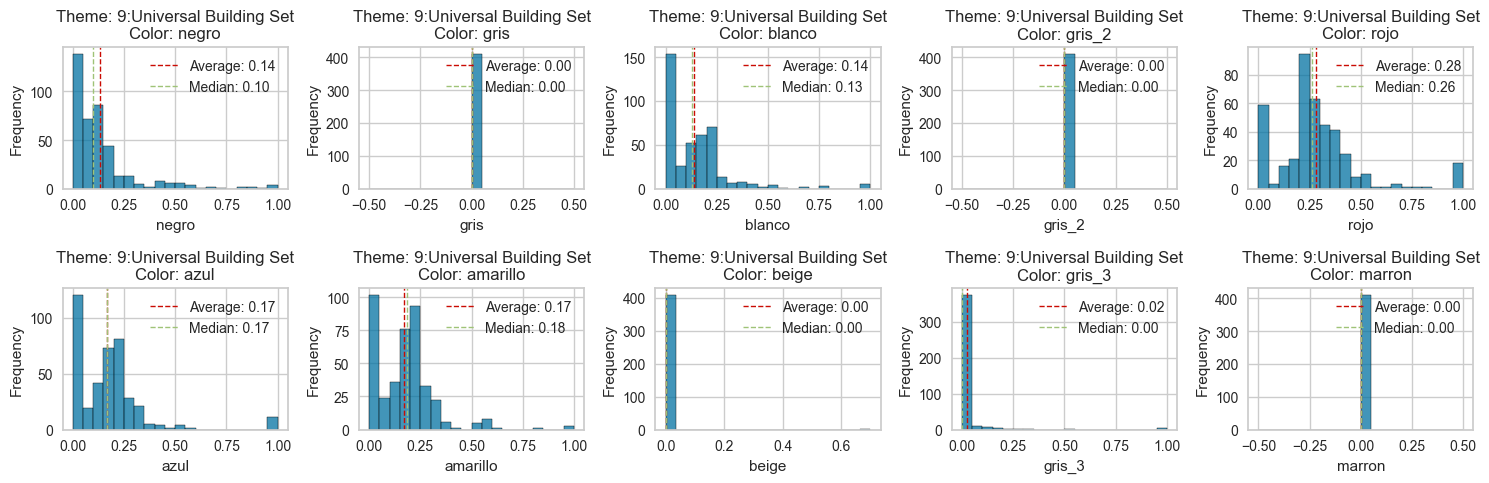

Descriptive Metrics for Theme 9:
            negro   gris      blanco  gris_2        rojo        azul  \
count  411.000000  411.0  411.000000   411.0  411.000000  411.000000   
mean     0.135349    0.0    0.139830     0.0    0.283485    0.169465   
std      0.176798    0.0    0.165924     0.0    0.210196    0.180977   
min      0.000000    0.0    0.000000     0.0    0.000000    0.000000   
25%      0.000000    0.0    0.000000     0.0    0.200000    0.000000   
50%      0.097674    0.0    0.130233     0.0    0.263027    0.168196   
75%      0.158387    0.0    0.203333     0.0    0.353207    0.223077   
max      1.000000    0.0    1.000000     0.0    1.000000    1.000000   

         amarillo       beige      gris_3  marron  
count  411.000000  411.000000  411.000000   411.0  
mean     0.171903    0.001703    0.023098     0.0  
std      0.148952    0.034528    0.108985     0.0  
min      0.000000    0.000000    0.000000     0.0  
25%      0.057743    0.000000    0.000000     0.0  
50%   

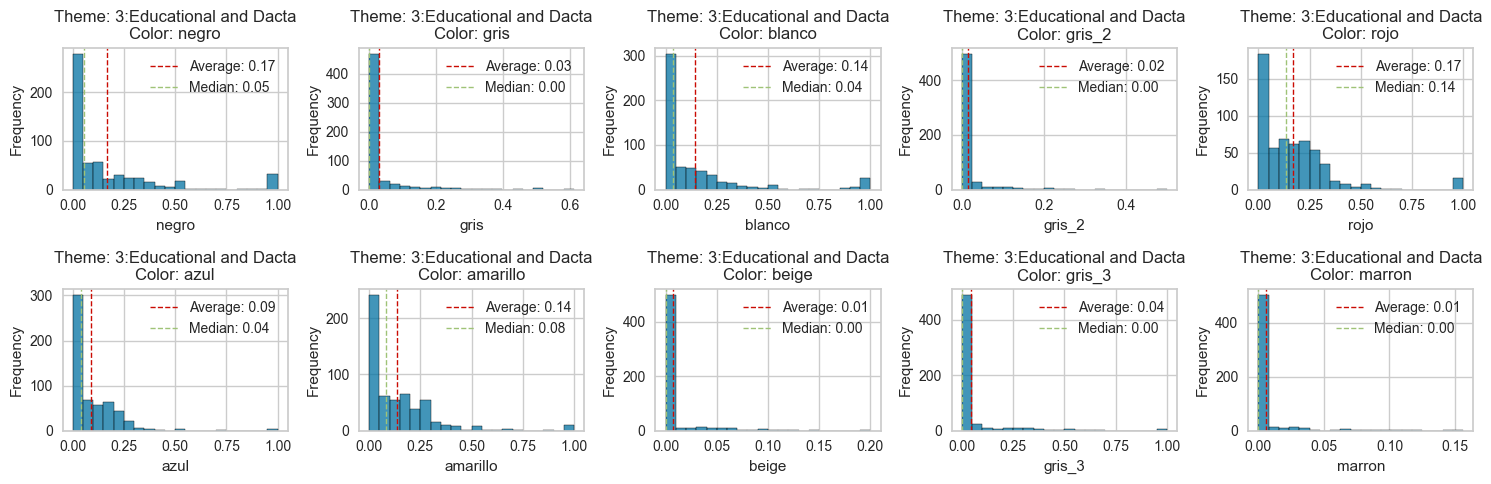

Descriptive Metrics for Theme 3:
            negro        gris      blanco      gris_2        rojo        azul  \
count  573.000000  573.000000  573.000000  573.000000  573.000000  573.000000   
mean     0.167153    0.028362    0.144751    0.015519    0.167460    0.087674   
std      0.257967    0.079003    0.245588    0.049755    0.192081    0.121557   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.053759    0.000000    0.036017    0.000000    0.135135    0.039624   
75%      0.231481    0.005988    0.178733    0.000000    0.239734    0.152626   
max      1.000000    0.611111    1.000000    0.500000    1.000000    1.000000   

         amarillo       beige      gris_3      marron  
count  573.000000  573.000000  573.000000  573.000000  
mean     0.136687    0.007007    0.044362    0.005889  
std      0.177187    0.021534    0.139337    0.020549  
min      0.00

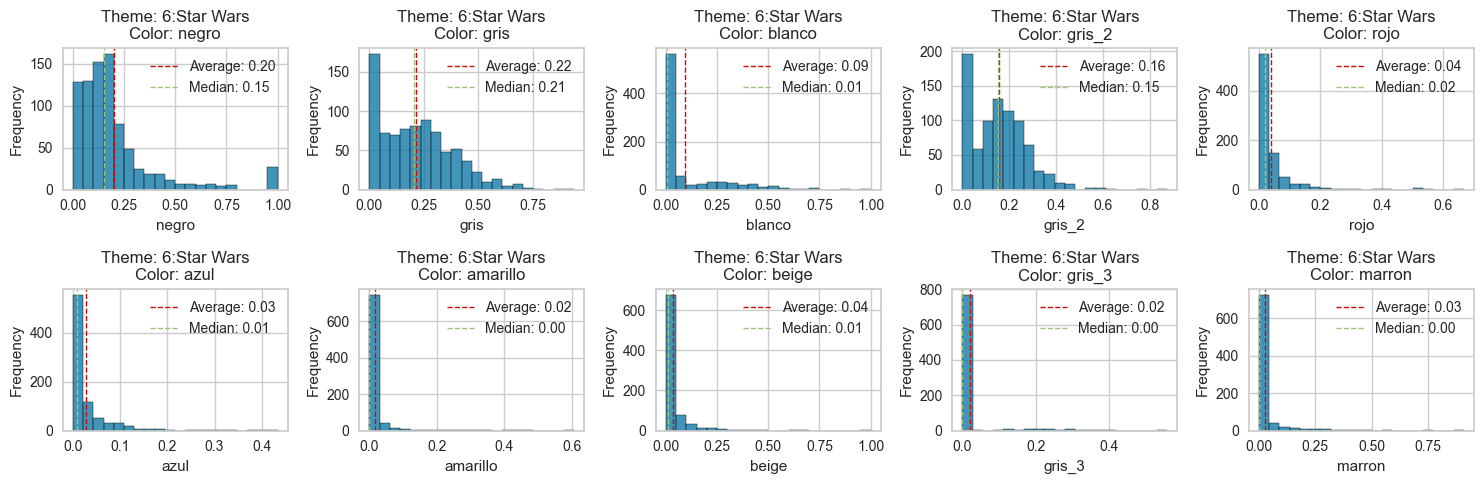

Descriptive Metrics for Theme 6:
            negro        gris      blanco      gris_2        rojo        azul  \
count  832.000000  832.000000  832.000000  832.000000  832.000000  832.000000   
mean     0.201262    0.216062    0.094052    0.155362    0.040375    0.028870   
std      0.205274    0.170611    0.161337    0.120571    0.075035    0.054104   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.083333    0.071271    0.000000    0.056800    0.000000    0.000000   
50%      0.152358    0.206143    0.007890    0.154366    0.018519    0.008214   
75%      0.227014    0.322881    0.118416    0.229514    0.045641    0.035359   
max      1.000000    0.941176    1.000000    0.875000    0.666667    0.433735   

         amarillo       beige      gris_3      marron  
count  832.000000  832.000000  832.000000  832.000000  
mean     0.015693    0.036604    0.019611    0.026152  
std      0.051215    0.082105    0.073201    0.078465  
min      0.00

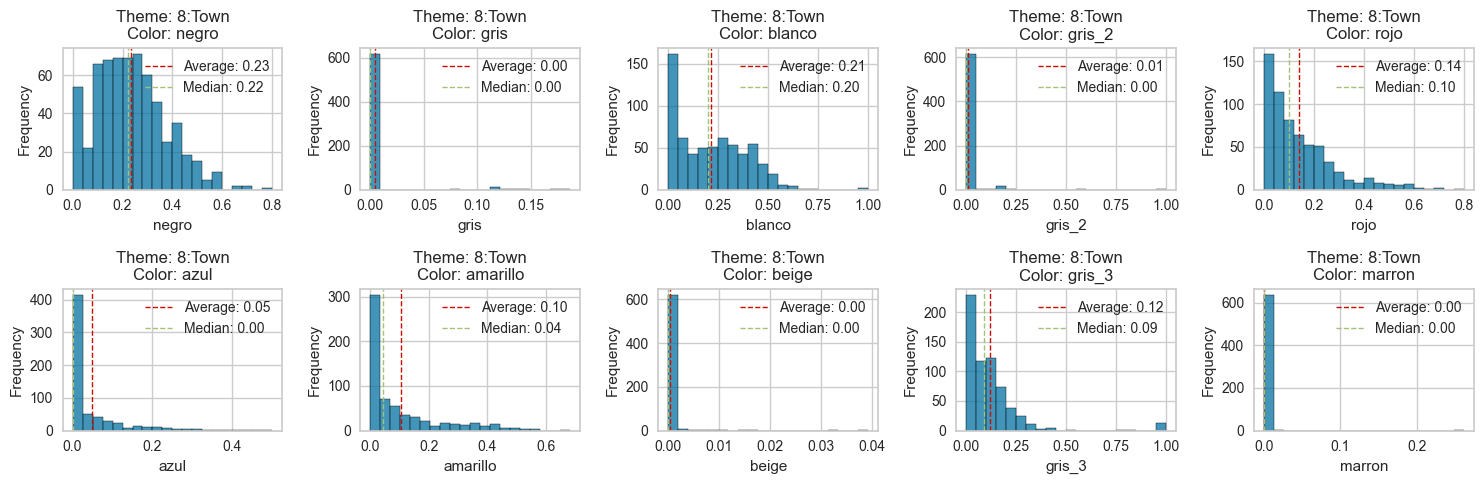

Descriptive Metrics for Theme 8:
            negro        gris      blanco      gris_2        rojo        azul  \
count  637.000000  637.000000  637.000000  637.000000  637.000000  637.000000   
mean     0.233124    0.004653    0.212622    0.008999    0.140602    0.048041   
std      0.141292    0.024546    0.174696    0.066037    0.138937    0.088641   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.129032    0.000000    0.048780    0.000000    0.040000    0.000000   
50%      0.222222    0.000000    0.200450    0.000000    0.100917    0.000000   
75%      0.318182    0.000000    0.350000    0.000000    0.202247    0.059459   
max      0.800000    0.186984    1.000000    1.000000    0.800000    0.500000   

         amarillo       beige      gris_3      marron  
count  637.000000  637.000000  637.000000  637.000000  
mean     0.103101    0.000324    0.117678    0.000506  
std      0.139723    0.002474    0.156231    0.010450  
min      0.00

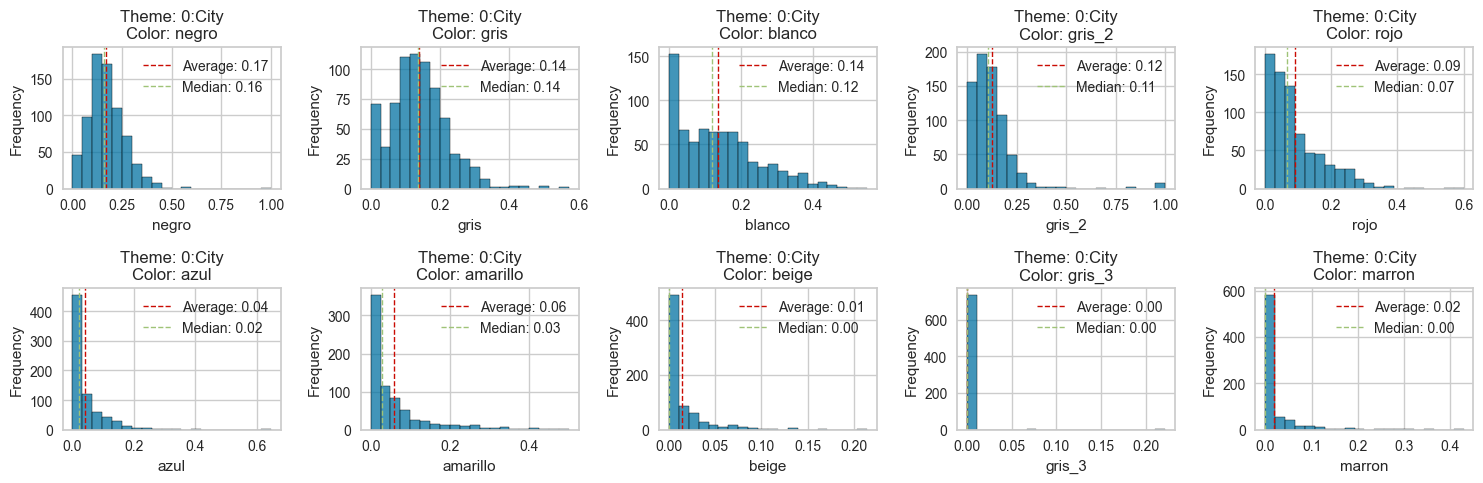

Descriptive Metrics for Theme 0:
            negro        gris      blanco      gris_2        rojo        azul  \
count  739.000000  739.000000  739.000000  739.000000  739.000000  739.000000   
mean     0.171686    0.139324    0.137148    0.124342    0.091222    0.041251   
std      0.094006    0.082279    0.113345    0.127734    0.085293    0.059408   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.111504    0.087528    0.040882    0.057433    0.031472    0.000000   
50%      0.157895    0.137324    0.118557    0.105263    0.066667    0.020772   
75%      0.221676    0.186220    0.202298    0.157838    0.129582    0.056506   
max      1.000000    0.571429    0.550000    1.000000    0.600000    0.645161   

         amarillo       beige      gris_3      marron  
count  739.000000  739.000000  739.000000  739.000000  
mean     0.059053    0.013673    0.000397    0.018454  
std      0.084153    0.025373    0.008583    0.043018  
min      0.00

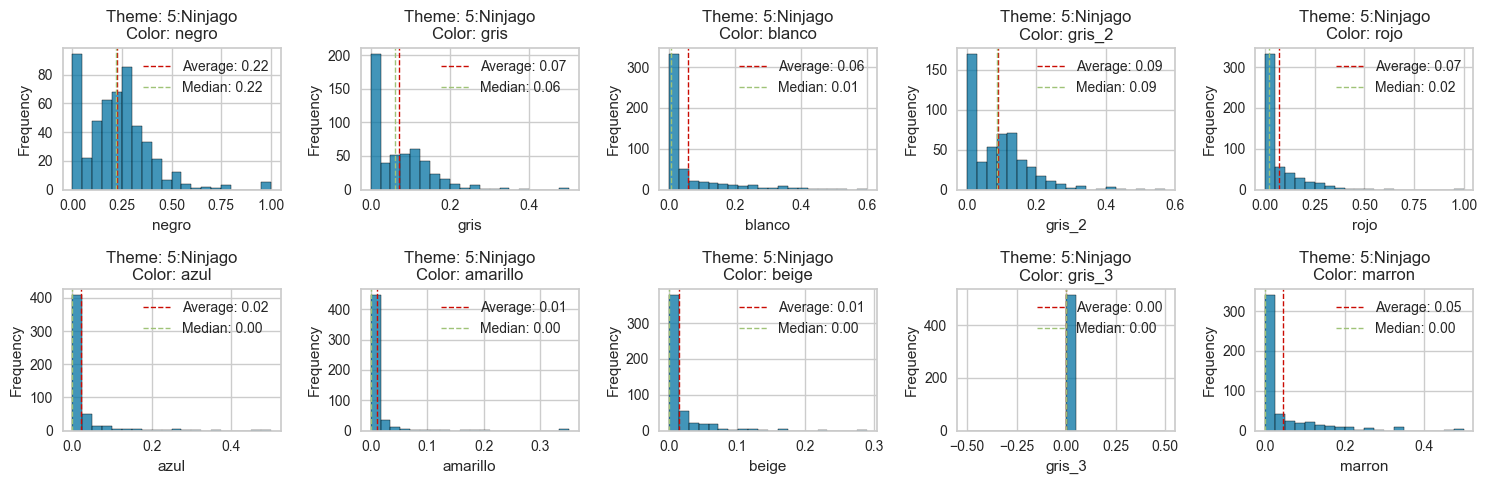

Descriptive Metrics for Theme 5:
            negro        gris      blanco      gris_2        rojo        azul  \
count  512.000000  512.000000  512.000000  512.000000  512.000000  512.000000   
mean     0.223361    0.071090    0.057331    0.090434    0.067992    0.022056   
std      0.168353    0.076708    0.101612    0.088271    0.117054    0.055652   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.120515    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.218316    0.061411    0.007674    0.085212    0.016310    0.000000   
75%      0.303488    0.116694    0.064153    0.135213    0.096641    0.018191   
max      1.000000    0.500000    0.600000    0.571429    1.000000    0.500000   

         amarillo       beige  gris_3      marron  
count  512.000000  512.000000   512.0  512.000000  
mean     0.010980    0.014591     0.0    0.045545  
std      0.042768    0.031557     0.0    0.085258  
min      0.000000    0.000000

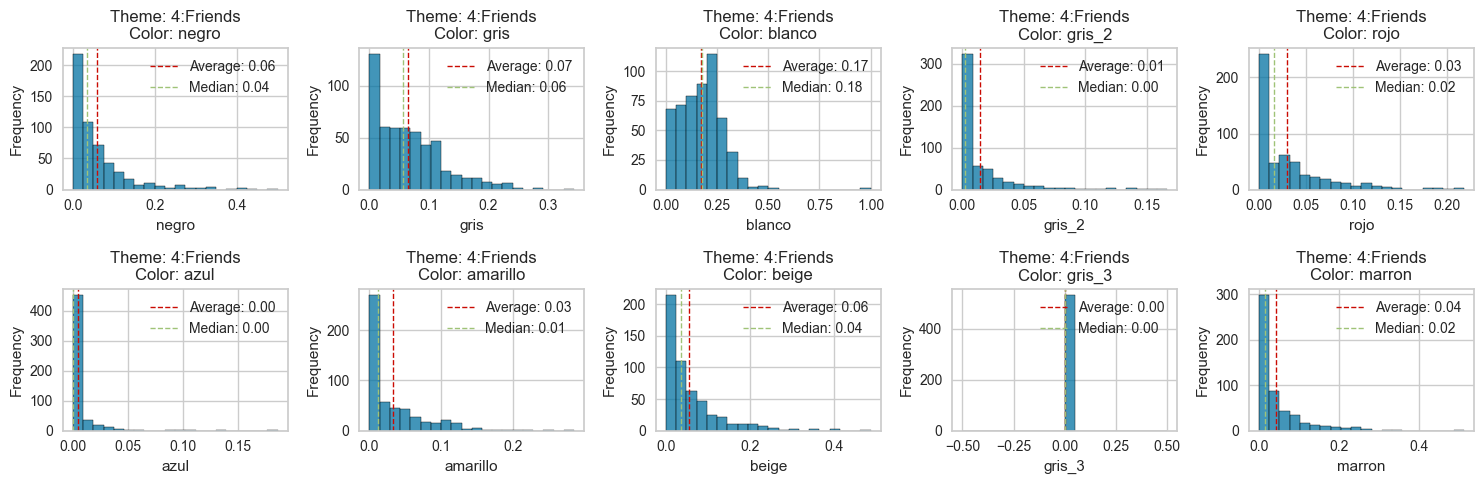

Descriptive Metrics for Theme 4:
            negro        gris      blanco      gris_2        rojo        azul  \
count  530.000000  530.000000  530.000000  530.000000  530.000000  530.000000   
mean     0.058125    0.065231    0.173232    0.014630    0.030203    0.004790   
std      0.073821    0.058608    0.104662    0.026093    0.039689    0.015099   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.008305    0.017959    0.096515    0.000000    0.000000    0.000000   
50%      0.035526    0.056435    0.178327    0.002118    0.016162    0.000000   
75%      0.075391    0.099433    0.238161    0.019589    0.042938    0.001799   
max      0.500000    0.343750    1.000000    0.166667    0.217391    0.186364   

         amarillo       beige  gris_3      marron  
count  530.000000  530.000000   530.0  530.000000  
mean     0.032208    0.056084     0.0    0.042054  
std      0.043753    0.068819     0.0    0.062741  
min      0.000000    0.000000

In [7]:
# Colores
colores = ['negro', 'gris', 'blanco', 'gris_2', 'rojo', 'azul', 'amarillo', 'beige', 'gris_3', 'marron']
themes = data['themes'].unique()

for theme in themes:
    theme_data = data[data['themes'] == theme]
    subset_data = theme_data[colores]
    metrics = subset_data.describe()
    
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(colores):
        plt.subplot(2, 5, i+1)
        sns.histplot(data=subset_data, x=color, bins=20)
        plt.title(f"Theme: {theme}:{clases_list[theme]}\nColor: {color}")
        plt.xlabel(color)
        plt.ylabel("Frequency")
        
        average = metrics.loc['mean', color]
        median = metrics.loc['50%', color]
        plt.axvline(average, color='r', linestyle='--', linewidth=1, label=f"Average: {average:.2f}")
        plt.axvline(median, color='g', linestyle='--', linewidth=1, label=f"Median: {median:.2f}")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Descriptive Metrics for Theme {theme}:")
    print(metrics)
    print()

##  Verificamos si algún material solo está presente en una clase

[inicio](#Tabla-de-contenido)

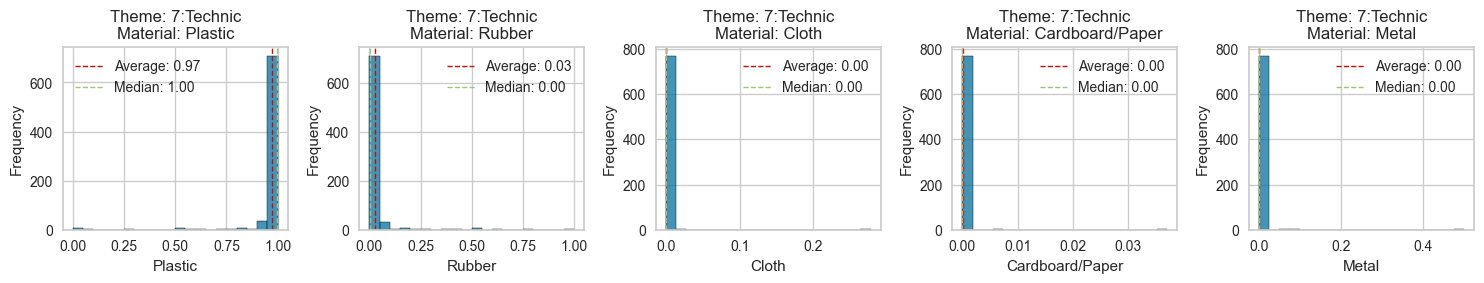

Descriptive Metrics for Theme 7:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  772.000000  772.000000  772.000000       772.000000  772.000000
mean     0.972463    0.025955    0.000640         0.000068    0.000874
std      0.105966    0.101847    0.010083         0.001379    0.018381
min      0.000000    0.000000    0.000000         0.000000    0.000000
25%      0.984041    0.000000    0.000000         0.000000    0.000000
50%      0.996338    0.003216    0.000000         0.000000    0.000000
75%      1.000000    0.015531    0.000000         0.000000    0.000000
max      1.000000    1.000000    0.277778         0.037037    0.500000



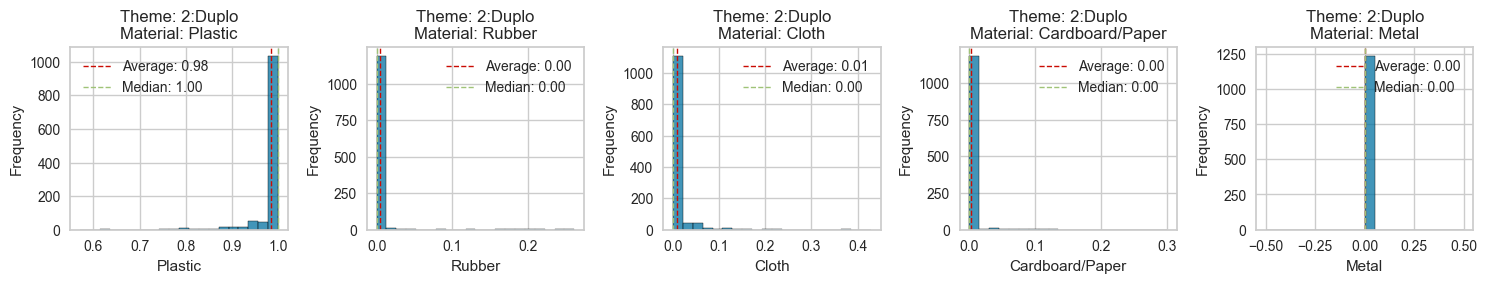

Descriptive Metrics for Theme 2:
           Plastic       Rubber        Cloth  Cardboard/Paper   Metal
count  1233.000000  1233.000000  1233.000000      1233.000000  1233.0
mean      0.984580     0.004630     0.007620         0.003170     0.0
std       0.045919     0.029087     0.031008         0.018873     0.0
min       0.571429     0.000000     0.000000         0.000000     0.0
25%       1.000000     0.000000     0.000000         0.000000     0.0
50%       1.000000     0.000000     0.000000         0.000000     0.0
75%       1.000000     0.000000     0.000000         0.000000     0.0
max       1.000000     0.260870     0.428571         0.300000     0.0



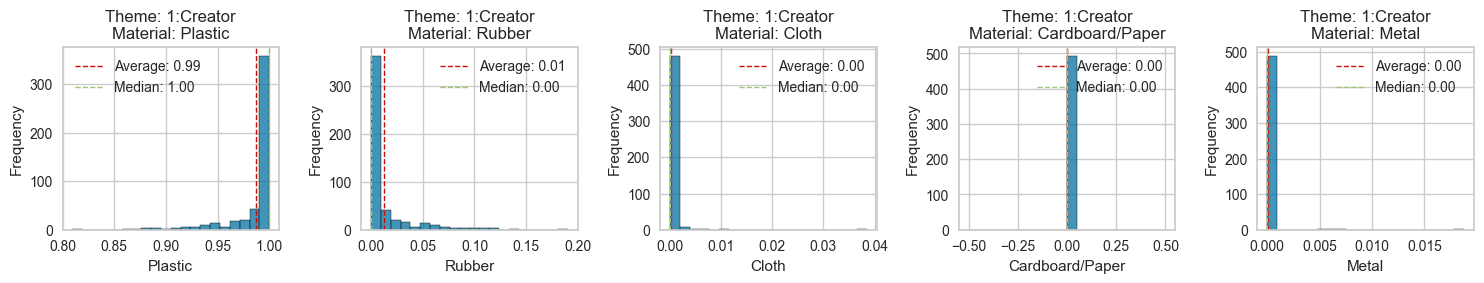

Descriptive Metrics for Theme 1:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  493.000000  493.000000  493.000000            493.0  493.000000
mean     0.987630    0.012074    0.000208              0.0    0.000089
std      0.025640    0.025638    0.001877              0.0    0.001014
min      0.809524    0.000000    0.000000              0.0    0.000000
25%      0.988395    0.000000    0.000000              0.0    0.000000
50%      1.000000    0.000000    0.000000              0.0    0.000000
75%      1.000000    0.010782    0.000000              0.0    0.000000
max      1.000000    0.190476    0.038462              0.0    0.018789



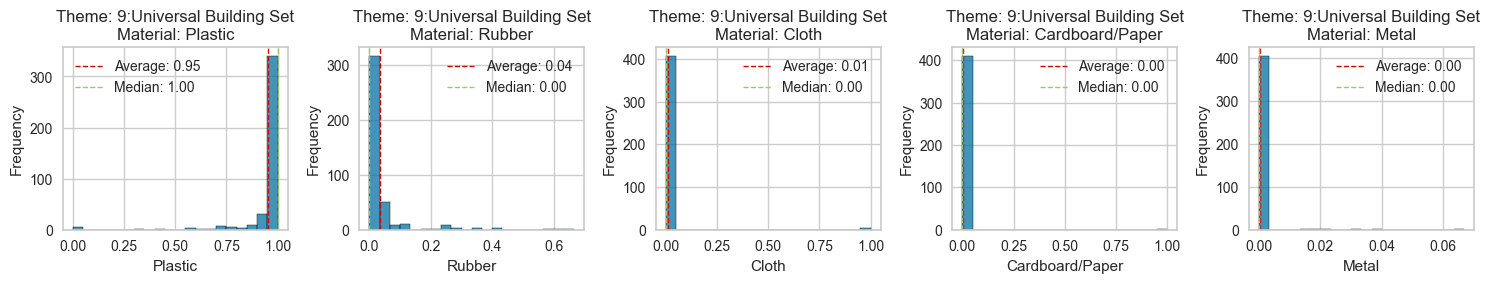

Descriptive Metrics for Theme 9:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  411.000000  411.000000  411.000000       411.000000  411.000000
mean     0.952049    0.035056    0.009942         0.002433    0.000519
std      0.134949    0.083810    0.098276         0.049326    0.004487
min      0.000000    0.000000    0.000000         0.000000    0.000000
25%      0.966527    0.000000    0.000000         0.000000    0.000000
50%      1.000000    0.000000    0.000000         0.000000    0.000000
75%      1.000000    0.031008    0.000000         0.000000    0.000000
max      1.000000    0.666667    1.000000         1.000000    0.066667



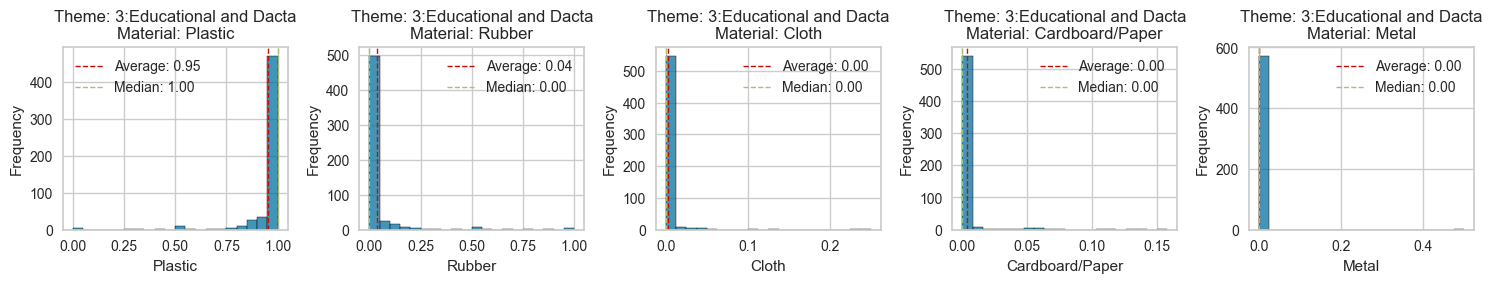

Descriptive Metrics for Theme 3:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  573.000000  573.000000  573.000000       573.000000  573.000000
mean     0.954058    0.038805    0.002877         0.003331    0.000929
std      0.135871    0.132093    0.019894         0.015974    0.020904
min      0.000000    0.000000    0.000000         0.000000    0.000000
25%      0.972906    0.000000    0.000000         0.000000    0.000000
50%      1.000000    0.000000    0.000000         0.000000    0.000000
75%      1.000000    0.011032    0.000000         0.000000    0.000000
max      1.000000    1.000000    0.250000         0.157895    0.500000



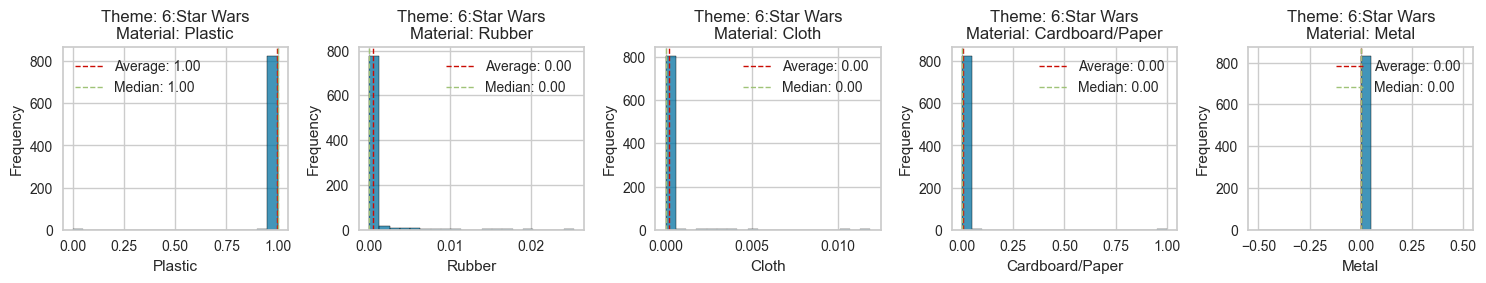

Descriptive Metrics for Theme 6:
          Plastic      Rubber       Cloth  Cardboard/Paper  Metal
count  832.000000  832.000000  832.000000       832.000000  832.0
mean     0.996064    0.000444    0.000189         0.003303    0.0
std      0.052091    0.002186    0.001270         0.052071    0.0
min      0.000000    0.000000    0.000000         0.000000    0.0
25%      1.000000    0.000000    0.000000         0.000000    0.0
50%      1.000000    0.000000    0.000000         0.000000    0.0
75%      1.000000    0.000000    0.000000         0.000000    0.0
max      1.000000    0.025316    0.011905         1.000000    0.0



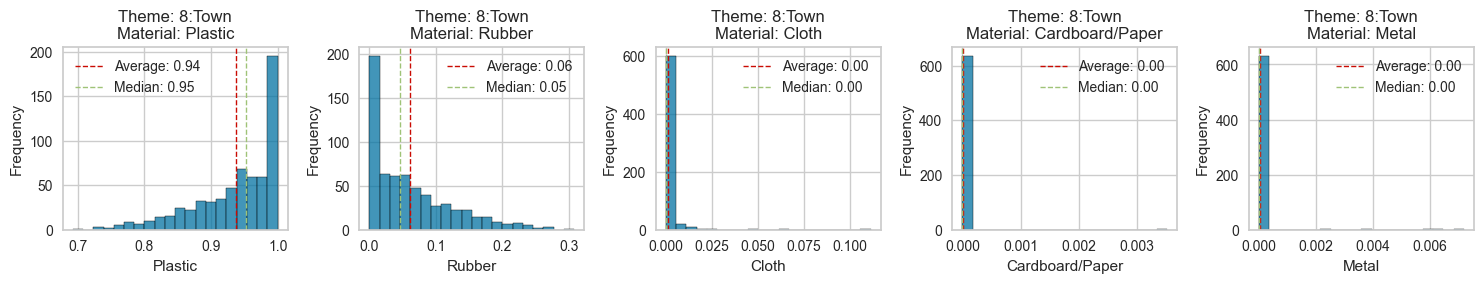

Descriptive Metrics for Theme 8:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  637.000000  637.000000  637.000000       637.000000  637.000000
mean     0.937472    0.061407    0.001070         0.000006    0.000046
std      0.063564    0.063541    0.006059         0.000140    0.000498
min      0.692308    0.000000    0.000000         0.000000    0.000000
25%      0.900000    0.000000    0.000000         0.000000    0.000000
50%      0.952381    0.045455    0.000000         0.000000    0.000000
75%      1.000000    0.096774    0.000000         0.000000    0.000000
max      1.000000    0.307692    0.111111         0.003521    0.007194



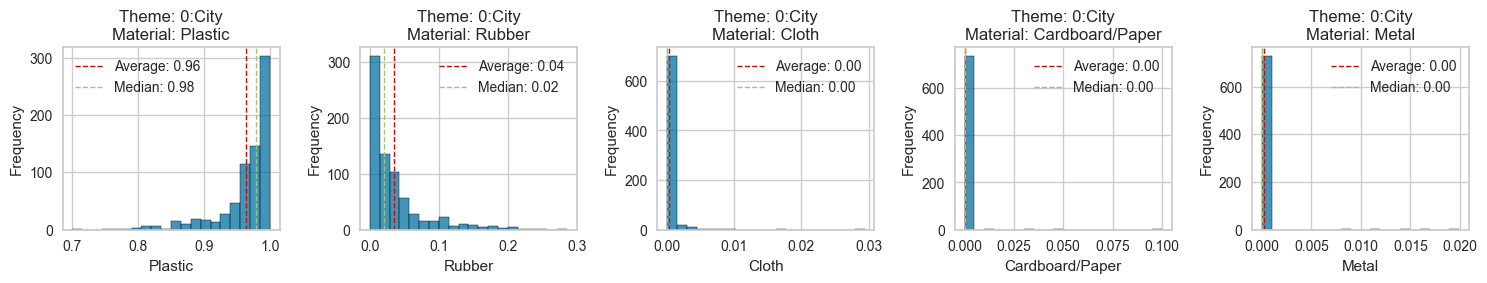

Descriptive Metrics for Theme 0:
          Plastic      Rubber       Cloth  Cardboard/Paper       Metal
count  739.000000  739.000000  739.000000       739.000000  739.000000
mean     0.964271    0.035011    0.000282         0.000262    0.000173
std      0.046675    0.046286    0.001574         0.004284    0.001531
min      0.700000    0.000000    0.000000         0.000000    0.000000
25%      0.956522    0.000000    0.000000         0.000000    0.000000
50%      0.978365    0.020725    0.000000         0.000000    0.000000
75%      1.000000    0.043478    0.000000         0.000000    0.000000
max      1.000000    0.285714    0.029412         0.100000    0.019960



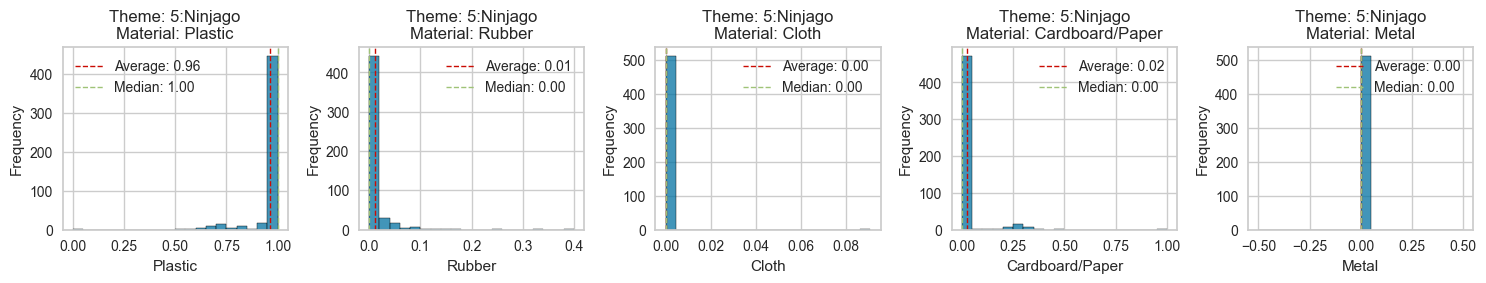

Descriptive Metrics for Theme 5:
          Plastic      Rubber       Cloth  Cardboard/Paper  Metal
count  512.000000  512.000000  512.000000        512.00000  512.0
mean     0.963749    0.011882    0.000219          0.02415    0.0
std      0.102209    0.037705    0.004029          0.09478    0.0
min      0.000000    0.000000    0.000000          0.00000    0.0
25%      0.984873    0.000000    0.000000          0.00000    0.0
50%      1.000000    0.000000    0.000000          0.00000    0.0
75%      1.000000    0.006584    0.000000          0.00000    0.0
max      1.000000    0.400000    0.090909          1.00000    0.0



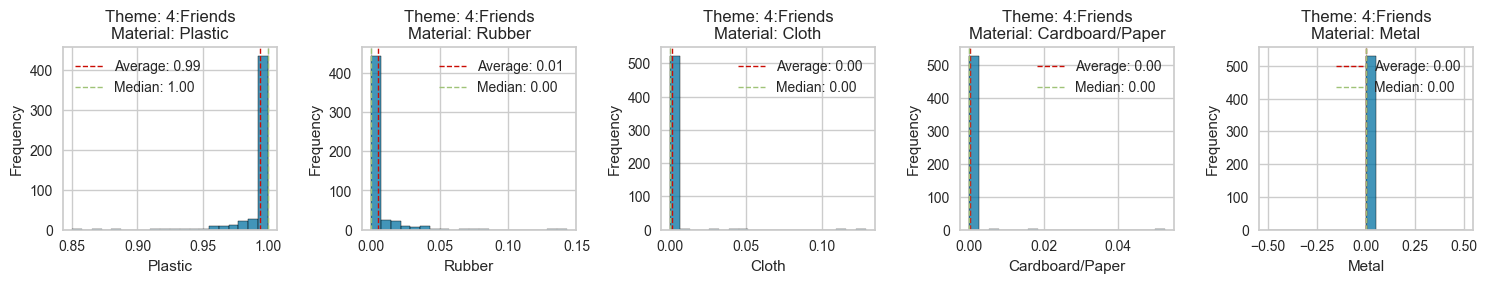

Descriptive Metrics for Theme 4:
          Plastic      Rubber       Cloth  Cardboard/Paper  Metal
count  530.000000  530.000000  530.000000       530.000000  530.0
mean     0.993858    0.005065    0.000934         0.000143    0.0
std      0.017276    0.014897    0.008547         0.002413    0.0
min      0.850000    0.000000    0.000000         0.000000    0.0
25%      0.997905    0.000000    0.000000         0.000000    0.0
50%      1.000000    0.000000    0.000000         0.000000    0.0
75%      1.000000    0.000000    0.000000         0.000000    0.0
max      1.000000    0.142857    0.129032         0.052632    0.0



In [8]:
# Materiales
materiales = ['Plastic', 'Rubber', 'Cloth', 'Cardboard/Paper', 'Metal']
themes = data['themes'].unique()

for theme in themes:
    theme_data = data[data['themes'] == theme]
    subset_data = theme_data[materiales]
    metrics = subset_data.describe()
    
    plt.figure(figsize=(15, 5))
    for i, material in enumerate(materiales):
        plt.subplot(2, 5, i+1)
        sns.histplot(data=subset_data, x=material, bins=20)
        plt.title(f"Theme: {theme}:{clases_list[theme]}\nMaterial: {material}")
        plt.xlabel(material)
        plt.ylabel("Frequency")
        
        average = metrics.loc['mean', material]
        median = metrics.loc['50%', material]
        plt.axvline(average, color='r', linestyle='--', linewidth=1, label=f"Average: {average:.2f}")
        plt.axvline(median, color='g', linestyle='--', linewidth=1, label=f"Median: {median:.2f}")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Descriptive Metrics for Theme {theme}:")
    print(metrics)
    print()

### Verificar el balance de clases
[inicio](#Tabla-de-contenido)

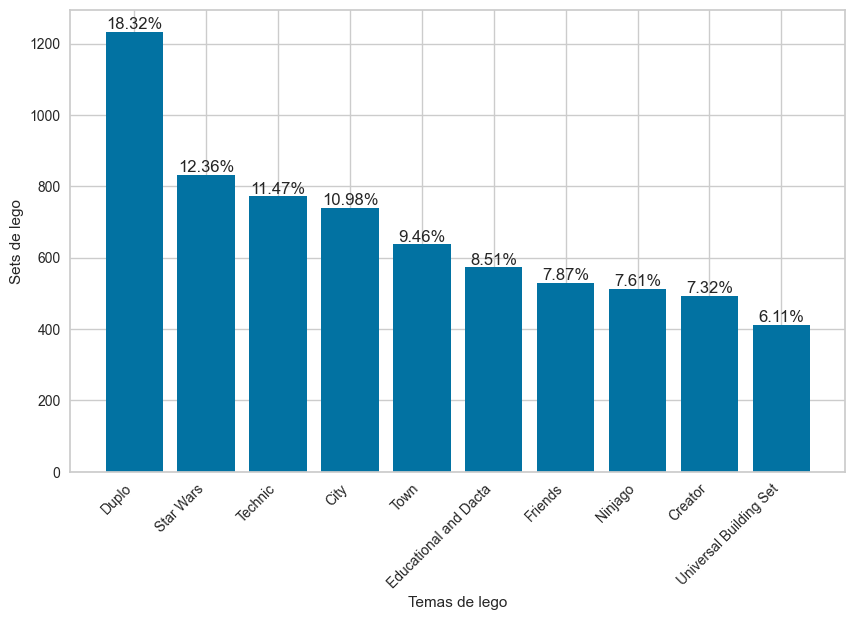

In [9]:
# Calcular counts y porcentajes
valid_categories = data["themes"]
category_counts = valid_categories.value_counts()
total_count = len(valid_categories)
category_percentages = (category_counts / total_count) * 100

# Grafico
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index.map(inv_clases), category_counts)
plt.xlabel("Temas de lego")
plt.ylabel("Sets de lego")

# Agregar porcentajes sobre las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    category = category_counts.index[i]
    if category in category_percentages:
        percentage = category_percentages[category]
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{percentage:.2f}%", ha="center", va="bottom")

plt.xticks(rotation=45, ha="right")
plt.show()

### Creamos la función 'evaluar' 

Para evaluar la performace de los diferentes modelos de la misma manera

[inicio](#Tabla-de-contenido)

In [10]:
themes_metrics = pd.DataFrame()
metrics = pd.DataFrame()

In [45]:
def evaluar(name, y_test, y_train, y_pred, y_pred_is):
    
    

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1:', f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test,y_pred, target_names=clases_list))

    
    cm = confusion_matrix(y_train, y_pred_is)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g', xticklabels=clases_list, yticklabels=clases_list)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - train data')
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g', xticklabels=clases_list, yticklabels=clases_list)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - test data')
    plt.show()

    #Crea un dataframe con las metricas de cada tematica por cada metodo  
    global themes_metrics 
    
    themes_metrics_metodo = pd.DataFrame(classification_report(y_test,y_pred, target_names=clases_list, output_dict=True)).reset_index()
    themes_metrics_metodo.rename(index=lambda x : name ,inplace=True)
    try:
        themes_metrics = themes_metrics.drop(name)
    except:
        pass
    themes_metrics = pd.concat([themes_metrics, themes_metrics_metodo], ignore_index=False)
    themes_metrics.sort_index()

    #Crea un dataframe con las metricas de cada metodo  
    global metrics 

    metrics_metodo = pd.DataFrame({'Accuracy': [accuracy_score(y_test, y_pred)], 'Precision': [precision_score(y_test, y_pred, average='weighted')],
                                   'Recall': [recall_score(y_test, y_pred, average='weighted')],'F1': [f1_score(y_test, y_pred, average='weighted')]})
    metrics_metodo.rename(index=lambda x : name ,inplace=True)

    try:
        metrics = metrics.drop(name)
    except:
        pass
    metrics = pd.concat([metrics, metrics_metodo], ignore_index=False)
    metrics.sort_index()



In [12]:
# Se seleccionaron 12 features basandonos en top 20 por MI y luego eliminando features correlacionadas entre si (Spearman)
features = ['Plates Special', 'Bricks', 'Duplo, Quatro and Primo', 'Minifig Accessories', 'gris', 'Bricks Sloped', 'negro',
            'Transportation - Land', 'Technic Pins', 'rojo', 'amarillo', 'Bars, Ladders and Fences']

In [13]:
data = pd.read_csv("./data/df_encoded.csv")
data.rename(columns={'0': 'themes'}, inplace=True)
cols = data.columns.tolist()
cols = [cols[-1]] + cols[:-1]
data = data[cols]

In [14]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = data[features]
y = data['themes']

## Separamos el dataset 

- Entrenamiento 70% 
- Test 30%

[inicio](#Tabla-de-contenido)

In [20]:

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
#Calculamos el balance de pesos de clases

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.9405189620758483,
 1: 1.4725,
 2: 0.5602853745541022,
 3: 1.1409200968523003,
 4: 1.2598930481283424,
 5: 1.290958904109589,
 6: 0.7827242524916943,
 7: 0.8567272727272728,
 8: 1.0424778761061948,
 9: 1.6027210884353742}

### Decision Tree Classifier
[inicio](#Tabla-de-contenido)

Accuracy: 0.6762376237623763
Precision: 0.666866705130454
Recall: 0.6762376237623763
F1: 0.6694304671695962
                        precision    recall  f1-score   support

                  City       0.65      0.61      0.63       238
               Creator       0.56      0.49      0.52       173
                 Duplo       0.87      0.89      0.88       392
 Educational and Dacta       0.32      0.25      0.28       160
               Friends       0.61      0.60      0.60       156
               Ninjago       0.59      0.54      0.57       147
             Star Wars       0.56      0.61      0.58       230
               Technic       0.73      0.92      0.82       222
                  Town       0.78      0.82      0.80       185
Universal Building Set       0.75      0.68      0.71       117

              accuracy                           0.68      2020
             macro avg       0.64      0.64      0.64      2020
          weighted avg       0.67      0.68      0.67     

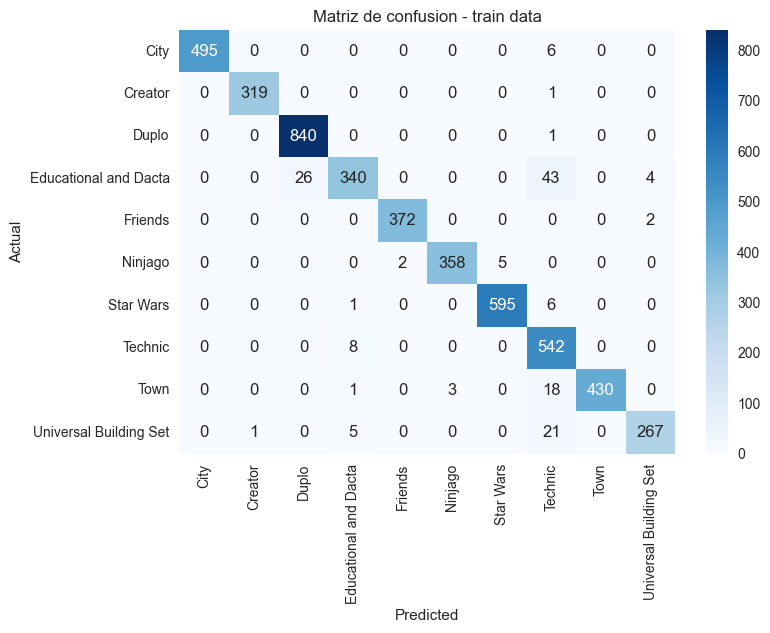

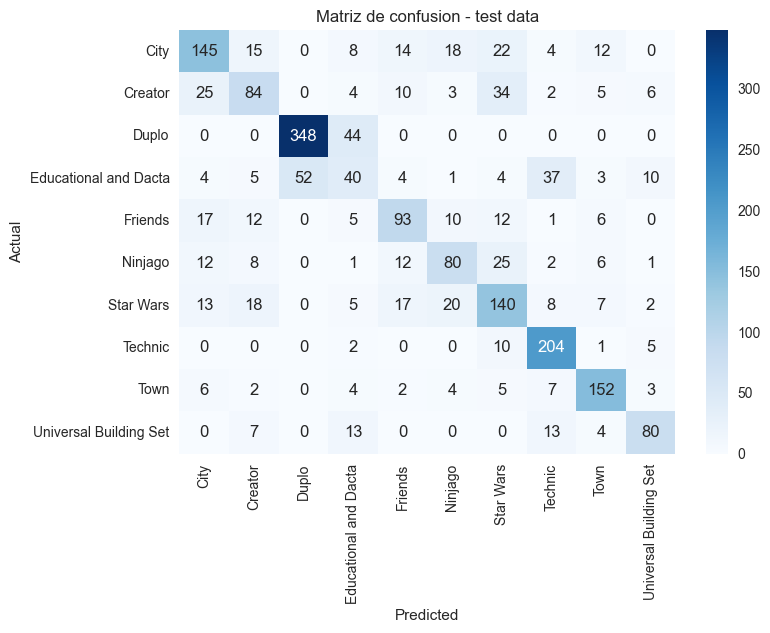

In [46]:
dt_clf = DecisionTreeClassifier(random_state=42)
#Train decesion tree classifier
dt_clf.fit(X_train, y_train)
#Predict the responde for test dataset
dt_clf_pred = dt_clf.predict(X_test)
dt_clf_pred_is = dt_clf.predict(X_train)
evaluar('Decision tree',y_test, y_train, dt_clf_pred, dt_clf_pred_is )

# LogisticRegressionCV

[inicio](#Tabla-de-contenido)

Accuracy: 0.7004950495049505
Precision: 0.6728577889721682
Recall: 0.7004950495049505
F1: 0.6801627268956199
                        precision    recall  f1-score   support

                  City       0.82      0.66      0.73       238
               Creator       0.53      0.58      0.56       173
                 Duplo       0.84      0.96      0.90       392
 Educational and Dacta       0.12      0.04      0.06       160
               Friends       0.66      0.76      0.70       156
               Ninjago       0.61      0.57      0.59       147
             Star Wars       0.68      0.56      0.61       230
               Technic       0.70      0.90      0.79       222
                  Town       0.79      0.79      0.79       185
Universal Building Set       0.61      0.83      0.71       117

              accuracy                           0.70      2020
             macro avg       0.64      0.67      0.64      2020
          weighted avg       0.67      0.70      0.68    

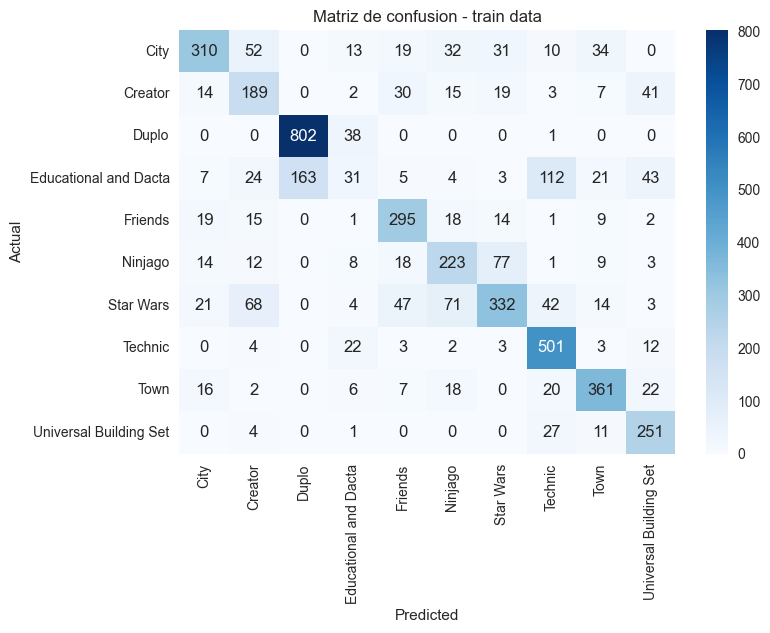

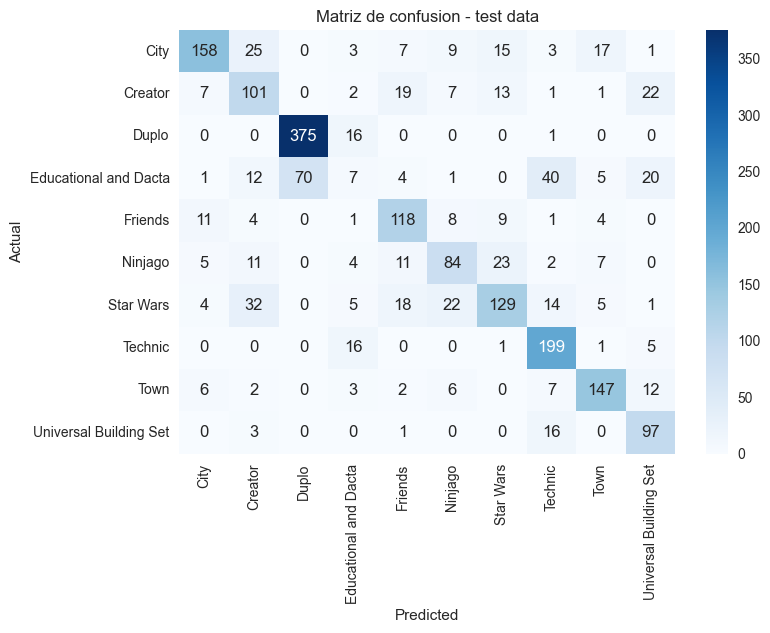

In [24]:
# Pruebo un log reg balanceado
lr_model = LogisticRegressionCV(random_state=42, class_weight='balanced', max_iter=10000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_is = lr_model.predict(X_train)

# Métricas de evaluación
evaluar('LRCV',y_test, y_train, y_pred_lr, y_pred_lr_is)


# XGB Classifier

[inicio](#Tabla-de-contenido)

Accuracy: 0.7643564356435644
Precision: 0.7481494425811996
Recall: 0.7643564356435644
F1: 0.7497234449205057
                        precision    recall  f1-score   support

                  City       0.76      0.75      0.76       238
               Creator       0.71      0.62      0.66       173
                 Duplo       0.86      0.96      0.91       392
 Educational and Dacta       0.47      0.20      0.28       160
               Friends       0.74      0.72      0.73       156
               Ninjago       0.70      0.66      0.68       147
             Star Wars       0.70      0.74      0.72       230
               Technic       0.76      0.96      0.85       222
                  Town       0.85      0.88      0.86       185
Universal Building Set       0.76      0.82      0.79       117

              accuracy                           0.76      2020
             macro avg       0.73      0.73      0.72      2020
          weighted avg       0.75      0.76      0.75    

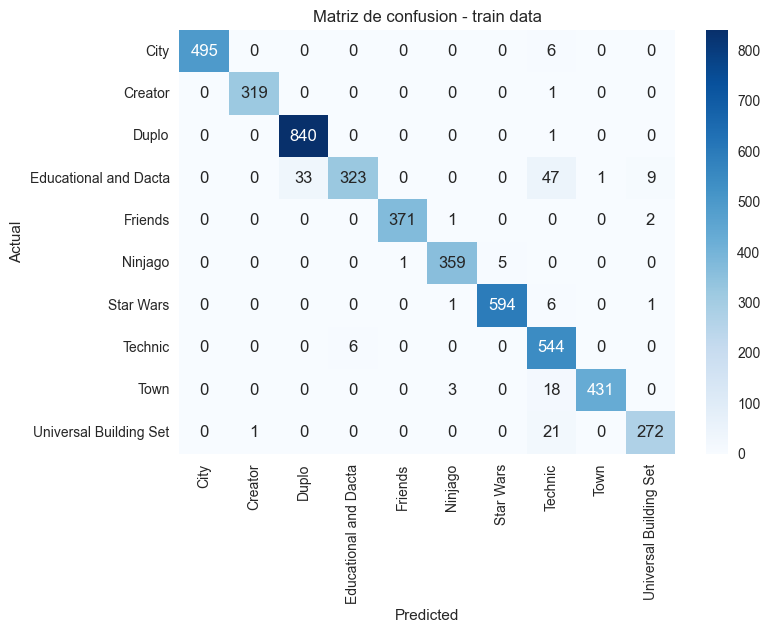

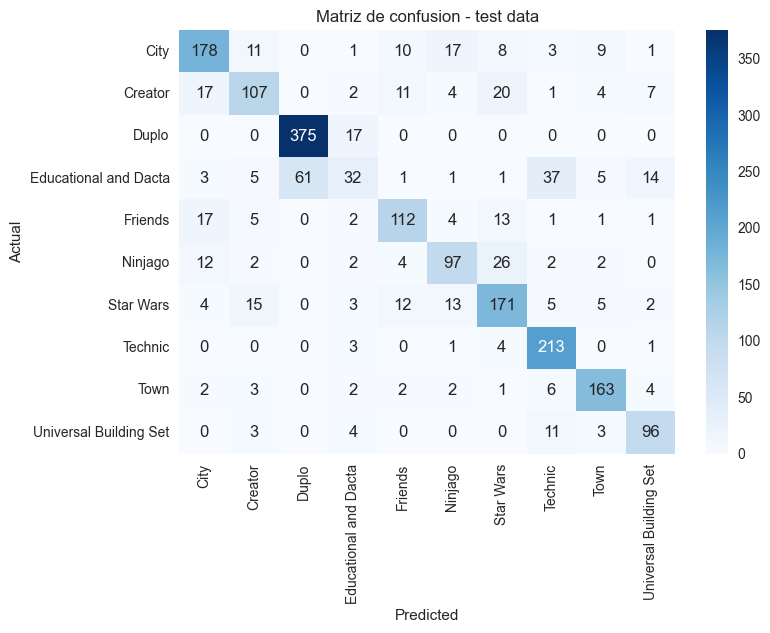

In [25]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_XGB = model.predict(X_test)
y_pred_XGB_is = model.predict(X_train)

# Métricas de evaluación
evaluar('XGB',y_test, y_train, y_pred_XGB, y_pred_XGB_is)



## Random Oversampling

In [26]:
ros_method = RandomOverSampler(sampling_strategy="minority")
X_resampled, y_resampled = ros_method.fit_resample(X_train, y_train)

# Logistic Regression with ROS

[inicio](#Tabla-de-contenido)

In [27]:
lregression_ros = LogisticRegression(max_iter=10000)
lregression_ros.fit(X_resampled, y_resampled)
y_ros_pred = lregression_ros.predict(X_test)
y_ros_pred_is = lregression_ros.predict(X_resampled)

Accuracy: 0.6193069306930693
Precision: 0.5923765974304945
Recall: 0.6193069306930693
F1: 0.5774393552032269
                        precision    recall  f1-score   support

                  City       0.71      0.58      0.64       238
               Creator       0.58      0.11      0.18       173
                 Duplo       0.84      0.97      0.90       392
 Educational and Dacta       0.00      0.00      0.00       160
               Friends       0.45      0.76      0.56       156
               Ninjago       0.64      0.31      0.42       147
             Star Wars       0.42      0.68      0.52       230
               Technic       0.71      0.69      0.70       222
                  Town       0.65      0.75      0.70       185
Universal Building Set       0.51      0.84      0.63       117

              accuracy                           0.62      2020
             macro avg       0.55      0.57      0.53      2020
          weighted avg       0.59      0.62      0.58    

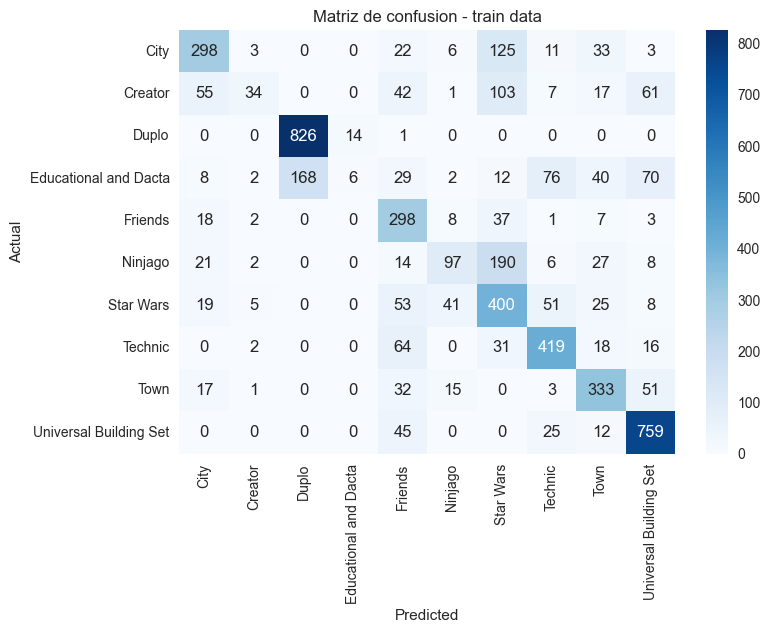

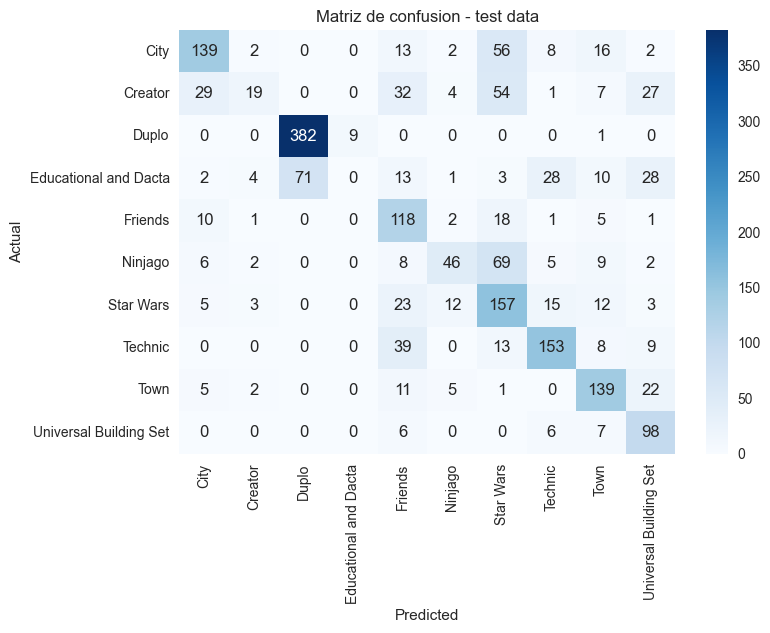

In [28]:
evaluar('LR_ROS',y_test, y_resampled, y_ros_pred, y_ros_pred_is)

# SMOTE

[inicio](#Tabla-de-contenido)

Accuracy: 0.7004950495049505
Precision: 0.6761224561886021
Recall: 0.7004950495049505
F1: 0.6823089292238065
                        precision    recall  f1-score   support

                  City       0.82      0.66      0.73       238
               Creator       0.53      0.57      0.55       173
                 Duplo       0.84      0.95      0.89       392
 Educational and Dacta       0.14      0.06      0.08       160
               Friends       0.70      0.74      0.72       156
               Ninjago       0.60      0.61      0.61       147
             Star Wars       0.68      0.57      0.62       230
               Technic       0.70      0.90      0.79       222
                  Town       0.79      0.79      0.79       185
Universal Building Set       0.62      0.82      0.70       117

              accuracy                           0.70      2020
             macro avg       0.64      0.67      0.65      2020
          weighted avg       0.68      0.70      0.68    

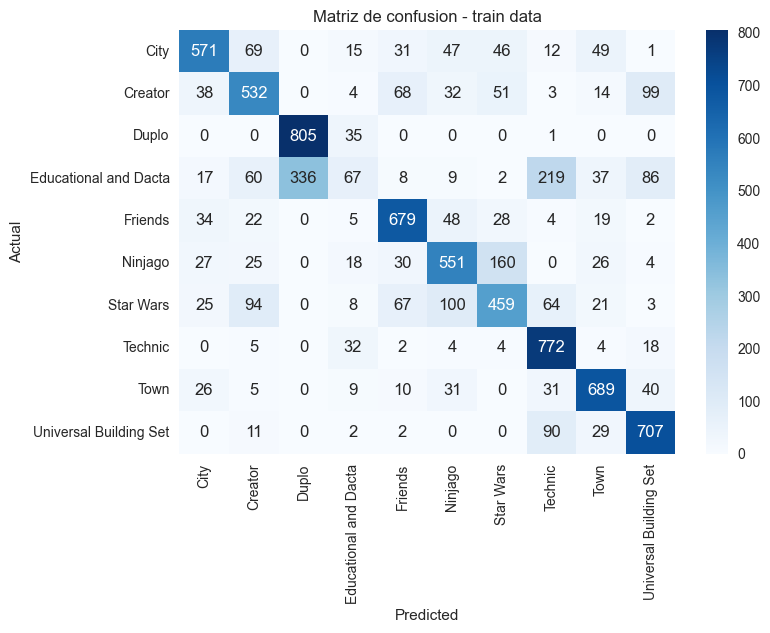

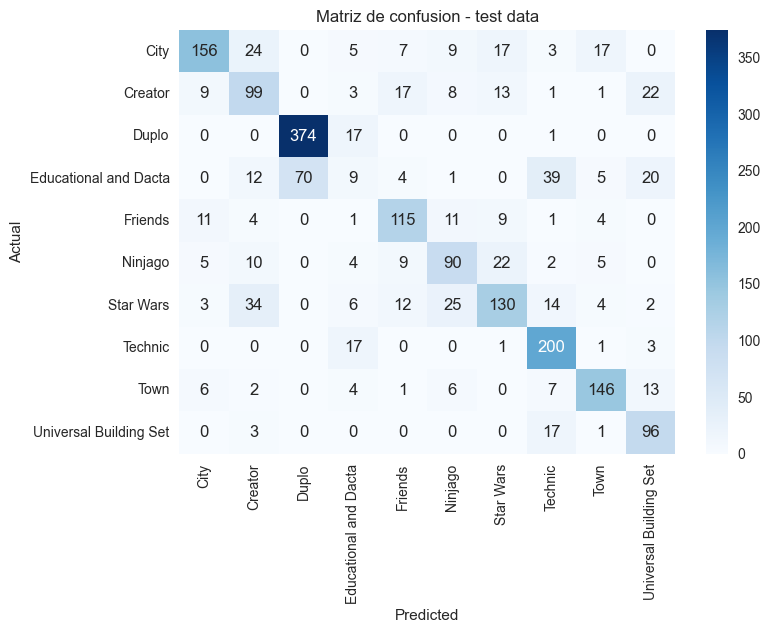

In [29]:

smote_method = SMOTE(random_state = 42)
#Apply resampling to the data training only
X_resampled_smote, y_resampled_smote = smote_method.fit_resample(X_train, y_train)
lregression_smote = LogisticRegressionCV(random_state=42, max_iter=10000)
lregression_smote.fit(X_resampled_smote, y_resampled_smote)
y_smote_pred = lregression_smote.predict(X_test)
y_smote_pred_is = lregression_smote.predict(X_resampled_smote)

evaluar('SMOTE',y_test, y_resampled_smote, y_smote_pred, y_smote_pred_is)

### Support Vector Machine
[inicio](#Tabla-de-contenido)

In [50]:
#Create a svm classifier
svm_clf = svm.SVC(kernel='rbf') # Linear Kernel

#Fit the model
svm_clf.fit(X_train, y_train)

#Train the model using the training sets
svm_clf_pred = svm_clf.predict(X_test)
svm_clf_pred_is = svm_clf.predict(X_train)

#Evaluate the results
evaluar('SMOTE',y_test, y_train, svm_clf_pred, svm_clf_pred_is)

ValueError: 'kbf' is not in list

# CatBoostClassifier

[inicio](#Tabla-de-contenido)

Accuracy: 0.7702970297029703
Precision: 0.7587803961495427
Recall: 0.7702970297029703
F1: 0.7608489533945552
                        precision    recall  f1-score   support

                  City       0.82      0.76      0.79       238
               Creator       0.71      0.66      0.68       173
                 Duplo       0.87      0.91      0.89       392
 Educational and Dacta       0.45      0.26      0.33       160
               Friends       0.75      0.80      0.78       156
               Ninjago       0.69      0.71      0.70       147
             Star Wars       0.74      0.71      0.73       230
               Technic       0.77      0.95      0.85       222
                  Town       0.85      0.88      0.86       185
Universal Building Set       0.73      0.82      0.77       117

              accuracy                           0.77      2020
             macro avg       0.74      0.75      0.74      2020
          weighted avg       0.76      0.77      0.76    

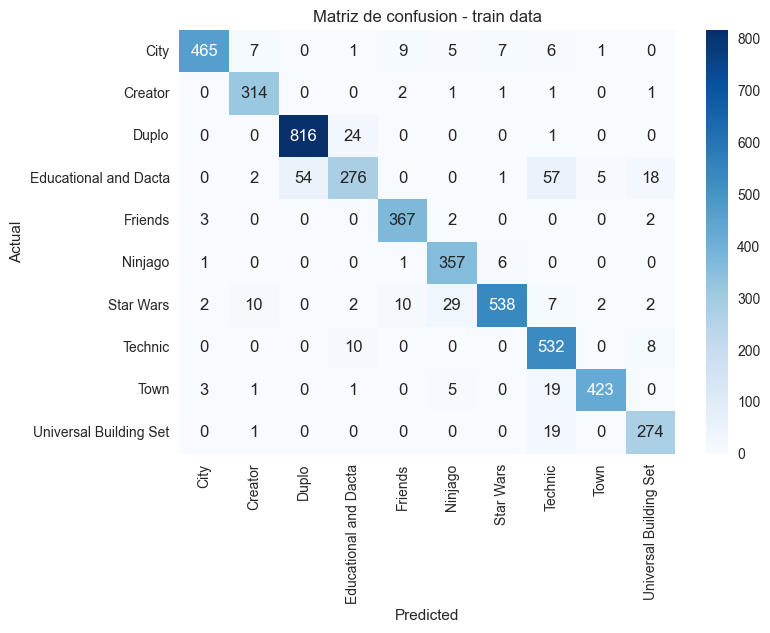

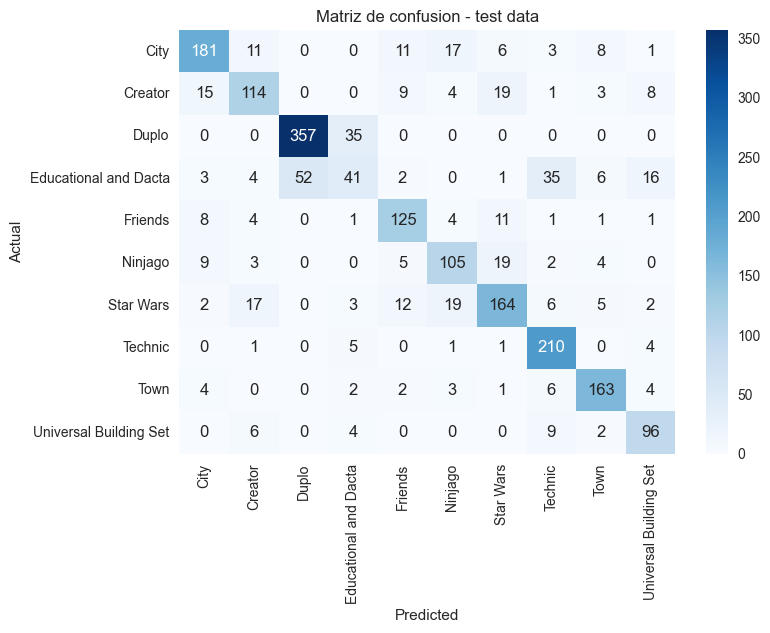

In [39]:
CatBoostC = CatBoostClassifier(border_count= 32, verbose= False,  random_state= 42, class_weights=class_weights)
CatBoostC.fit(X_train, y_train)
y_pred = CatBoostC.predict(X_test)
y_pred_is = CatBoostC.predict(X_train)

# Métricas de evaluación
evaluar('CatBoostC', y_test, y_train, y_pred, y_pred_is)

# RandomForestClassifier

[inicio](#Tabla-de-contenido)

In [31]:
clrfc = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced' , random_state=42)
clrfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

In [32]:
y_rfc_pred = clrfc.predict(X_test)
y_rfc_pred_is = clrfc.predict(X_train)

Accuracy: 0.7707920792079208
Precision: 0.7598828899679837
Recall: 0.7707920792079208
F1: 0.754743797272308
                        precision    recall  f1-score   support

                  City       0.77      0.76      0.77       238
               Creator       0.80      0.57      0.67       173
                 Duplo       0.86      0.97      0.91       392
 Educational and Dacta       0.57      0.21      0.30       160
               Friends       0.72      0.72      0.72       156
               Ninjago       0.69      0.67      0.68       147
             Star Wars       0.69      0.77      0.73       230
               Technic       0.77      0.95      0.85       222
                  Town       0.83      0.89      0.86       185
Universal Building Set       0.75      0.85      0.80       117

              accuracy                           0.77      2020
             macro avg       0.74      0.74      0.73      2020
          weighted avg       0.76      0.77      0.75     

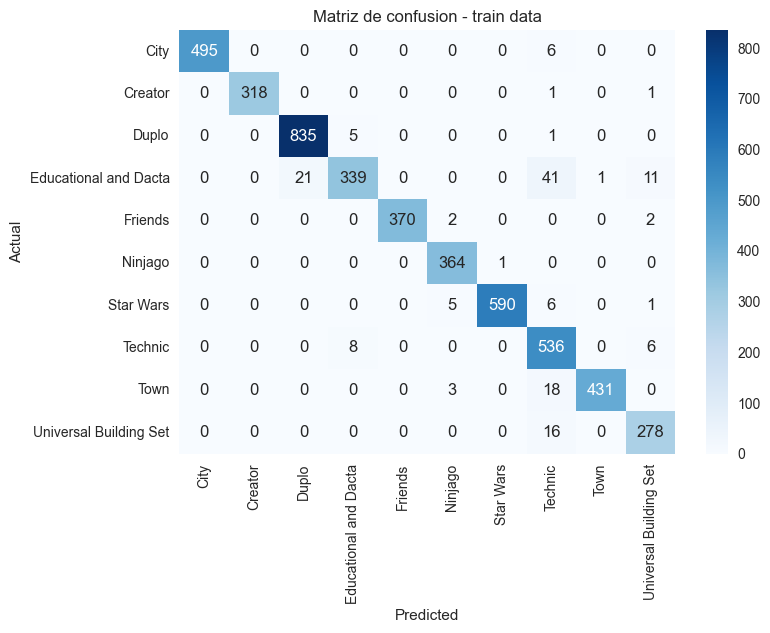

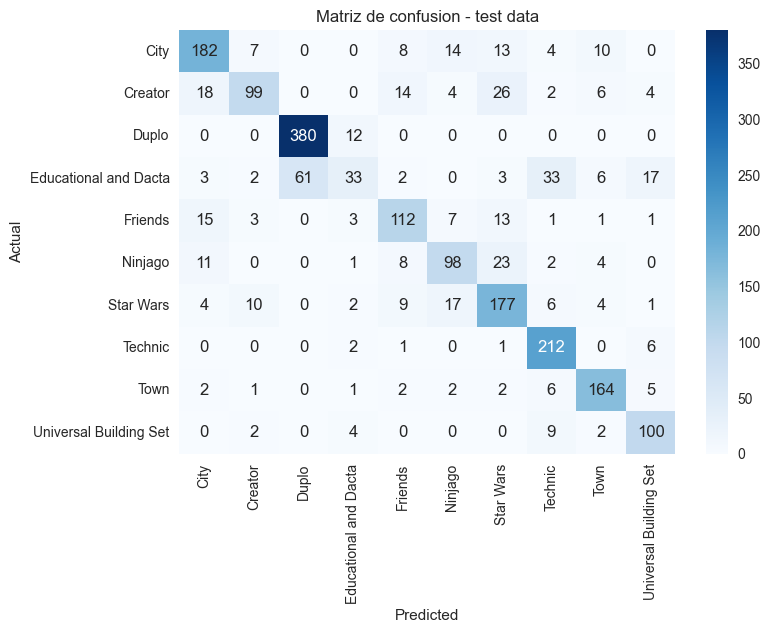

In [33]:
evaluar('RFC',y_test, y_train, y_rfc_pred, y_rfc_pred_is)

# Bagging

[inicio](#Tabla-de-contenido)

In [34]:

clftree = tree.DecisionTreeClassifier()

In [35]:
bag_clf = BaggingClassifier(base_estimator=clftree, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)

In [36]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, random_state=42)

In [37]:
y_bag_pred = bag_clf.predict(X_test)
y_bag_pred_is = bag_clf.predict(X_train)

Accuracy: 0.7569306930693069
Precision: 0.7441454705013452
Recall: 0.7569306930693069
F1: 0.7435947433819929
                        precision    recall  f1-score   support

                  City       0.77      0.73      0.75       238
               Creator       0.73      0.58      0.65       173
                 Duplo       0.87      0.97      0.92       392
 Educational and Dacta       0.51      0.23      0.32       160
               Friends       0.74      0.71      0.73       156
               Ninjago       0.63      0.64      0.64       147
             Star Wars       0.65      0.71      0.68       230
               Technic       0.76      0.94      0.84       222
                  Town       0.82      0.89      0.85       185
Universal Building Set       0.80      0.81      0.81       117

              accuracy                           0.76      2020
             macro avg       0.73      0.72      0.72      2020
          weighted avg       0.74      0.76      0.74    

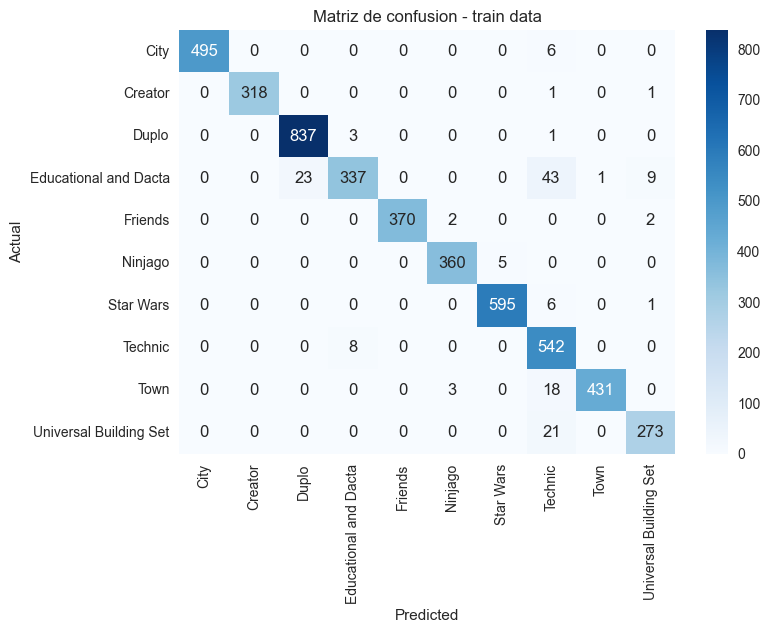

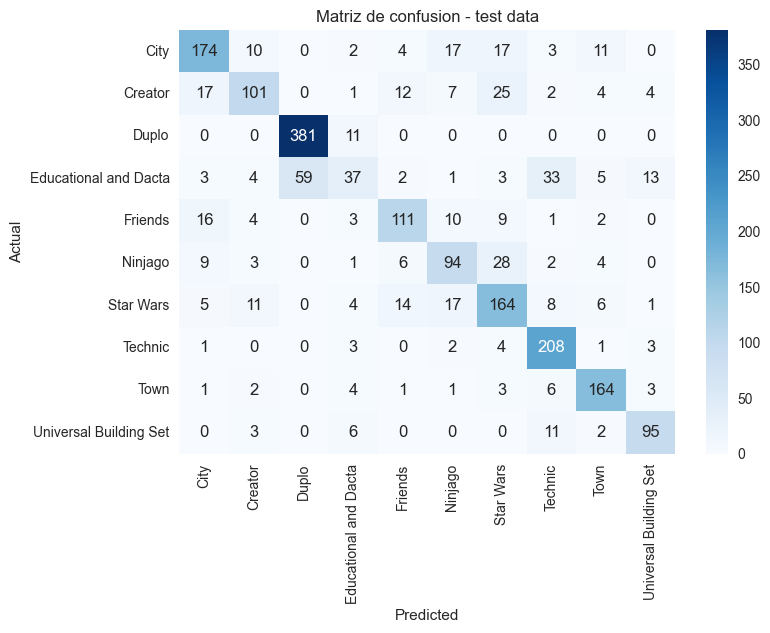

In [38]:
evaluar('Bagg', y_test, y_train, y_bag_pred, y_bag_pred_is)

# Comparacion de los modelos

In [40]:
metrics

Accuracy  Precision    Recall        F1
Decision tree  0.676238   0.666867  0.676238  0.669430
LRCV           0.700495   0.672858  0.700495  0.680163
XGB            0.764356   0.748149  0.764356  0.749723
LR_ROS         0.619307   0.592377  0.619307  0.577439
SMOTE          0.700495   0.676122  0.700495  0.682309
RFC            0.770792   0.759883  0.770792  0.754744
Bagg           0.756931   0.744145  0.756931  0.743595
CatBoostC      0.770297   0.758780  0.770297  0.760849

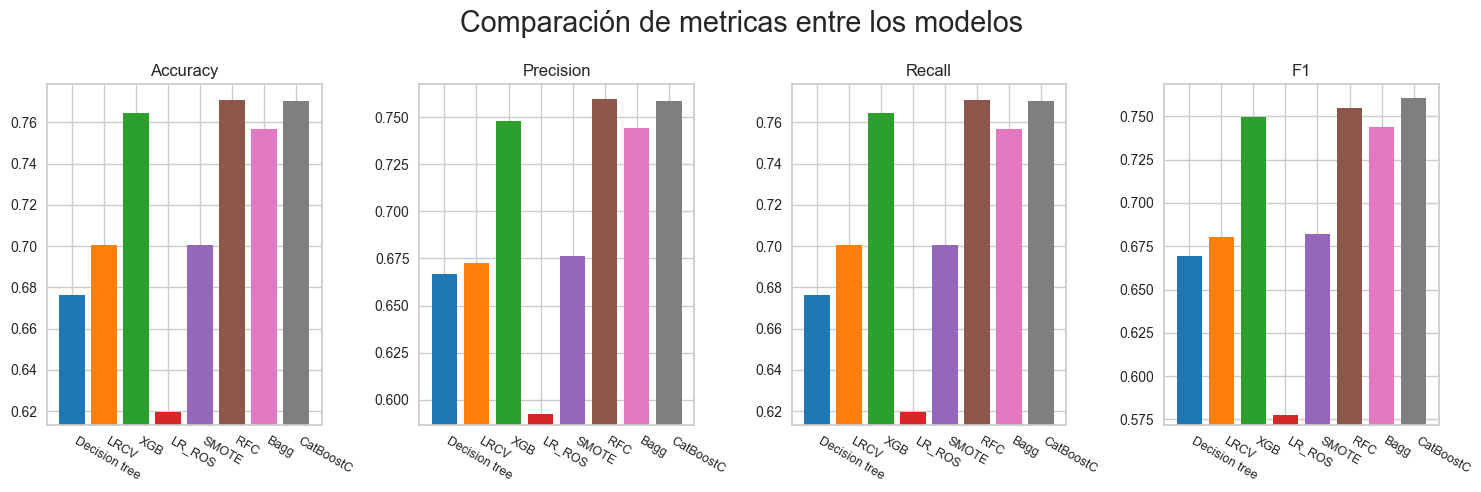

In [41]:
colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(1,4,figsize=(15, 5))
for ax, m in zip(axs.flat, metrics.columns):
    p = ax.bar(metrics.index, metrics[m], color=colors)
    ax.set_title(m)
    ax.set_ylim(bottom=(metrics[m].min()*0.99), top=(metrics[m].max()*1.01))
    #ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    #ax.bar_label(p, label_type='center')
    plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')

for ax in axs.flat[len(metrics.columns):]:
    ax.remove()

fig.suptitle('Comparación de metricas entre los modelos', fontsize = 'xx-large')
fig.tight_layout()
plt.show()

In [42]:
themes_metrics

index        City     Creator       Duplo  \
Decision tree  precision    0.653153    0.556291    0.870000   
Decision tree     recall    0.609244    0.485549    0.887755   
Decision tree   f1-score    0.630435    0.518519    0.878788   
Decision tree    support  238.000000  173.000000  392.000000   
LRCV           precision    0.822917    0.531579    0.842697   
LRCV              recall    0.663866    0.583815    0.956633   
LRCV            f1-score    0.734884    0.556474    0.896057   
LRCV             support  238.000000  173.000000  392.000000   
XGB            precision    0.763948    0.708609    0.860092   
XGB               recall    0.747899    0.618497    0.956633   
XGB             f1-score    0.755839    0.660494    0.905797   
XGB              support  238.000000  173.000000  392.000000   
LR_ROS         precision    0.709184    0.575758    0.843267   
LR_ROS            recall    0.584034    0.109827    0.974490   
LR_ROS          f1-score    0.640553    0.184466    0.904142   
LR_ROS           support  238.000000  173.000000  392.000000   
SMOTE          precision    0.821053    0.526596    0.842342   
SMOTE             recall    0.655462    0.572254    0.954082   
SMOTE           f1-score    0.728972    0.548476    0.894737   
SMOTE            support  238.000000  173.000000  392.000000   
RFC            precision    0.774468    0.798387    0.861678   
RFC               recall    0.764706    0.572254    0.969388   
RFC             f1-score    0.769556    0.666667    0.912365   
RFC              support  238.000000  173.000000  392.000000   
Bagg           precision    0.769912    0.731884    0.865909   
Bagg              recall    0.731092    0.583815    0.971939   
Bagg            f1-score    0.750000    0.649518    0.915865   
Bagg             support  238.000000  173.000000  392.000000   
CatBoostC      precision    0.815315    0.712500    0.872861   
CatBoostC         recall    0.760504    0.658960    0.910714   
CatBoostC       f1-score    0.786957    0.684685    0.891386   
CatBoostC        support  238.000000  173.000000  392.000000   

               Educational and Dacta     Friends     Ninjago   Star Wars  \
Decision tree               0.317460    0.611842    0.588235    0.555556   
Decision tree               0.250000    0.596154    0.544218    0.608696   
Decision tree               0.279720    0.603896    0.565371    0.580913   
Decision tree             160.000000  156.000000  147.000000  230.000000   
LRCV                        0.122807    0.655556    0.613139    0.678947   
LRCV                        0.043750    0.756410    0.571429    0.560870   
LRCV                        0.064516    0.702381    0.591549    0.614286   
LRCV                      160.000000  156.000000  147.000000  230.000000   
XGB                         0.470588    0.736842    0.697842    0.700820   
XGB                         0.200000    0.717949    0.659864    0.743478   
XGB                         0.280702    0.727273    0.678322    0.721519   
XGB                       160.000000  156.000000  147.000000  230.000000   
LR_ROS                      0.000000    0.448669    0.638889    0.423181   
LR_ROS                      0.000000    0.756410    0.312925    0.682609   
LR_ROS                      0.000000    0.563246    0.420091    0.522463   
LR_ROS                    160.000000  156.000000  147.000000  230.000000   
SMOTE                       0.136364    0.696970    0.600000    0.677083   
SMOTE                       0.056250    0.737179    0.612245    0.565217   
SMOTE                       0.079646    0.716511    0.606061    0.616114   
SMOTE                     160.000000  156.000000  147.000000  230.000000   
RFC                         0.568966    0.717949    0.690141    0.686047   
RFC                         0.206250    0.717949    0.666667    0.769565   
RFC                         0.302752    0.717949    0.678201    0.725410   
RFC                       160.000000  156.000000  147.000000  230.000000   
Bagg  

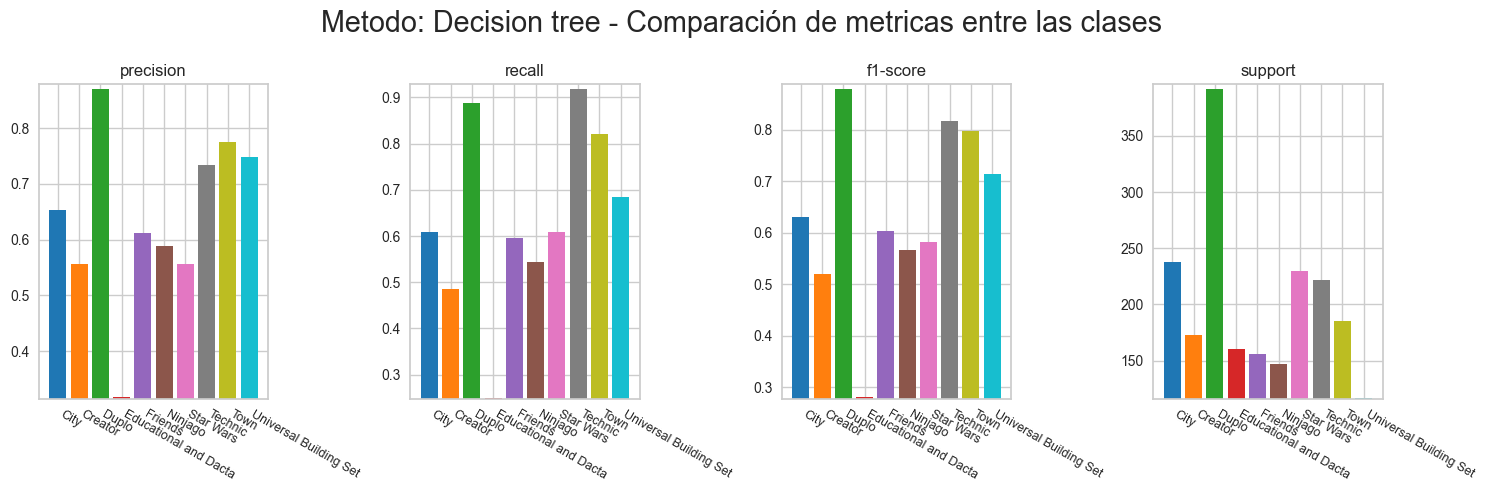

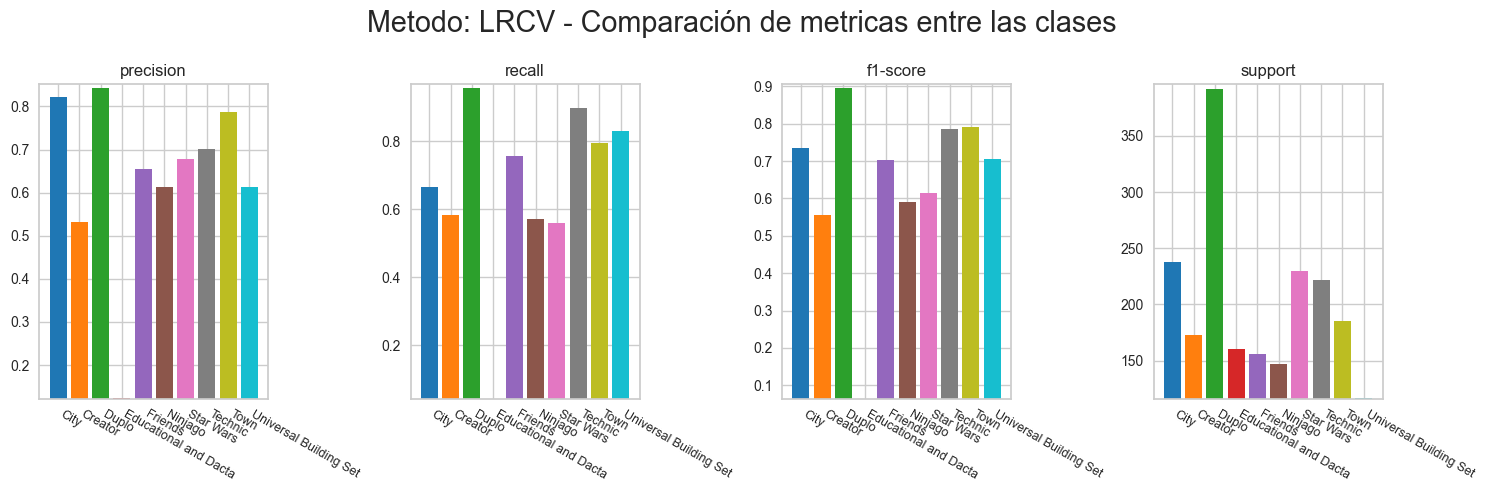

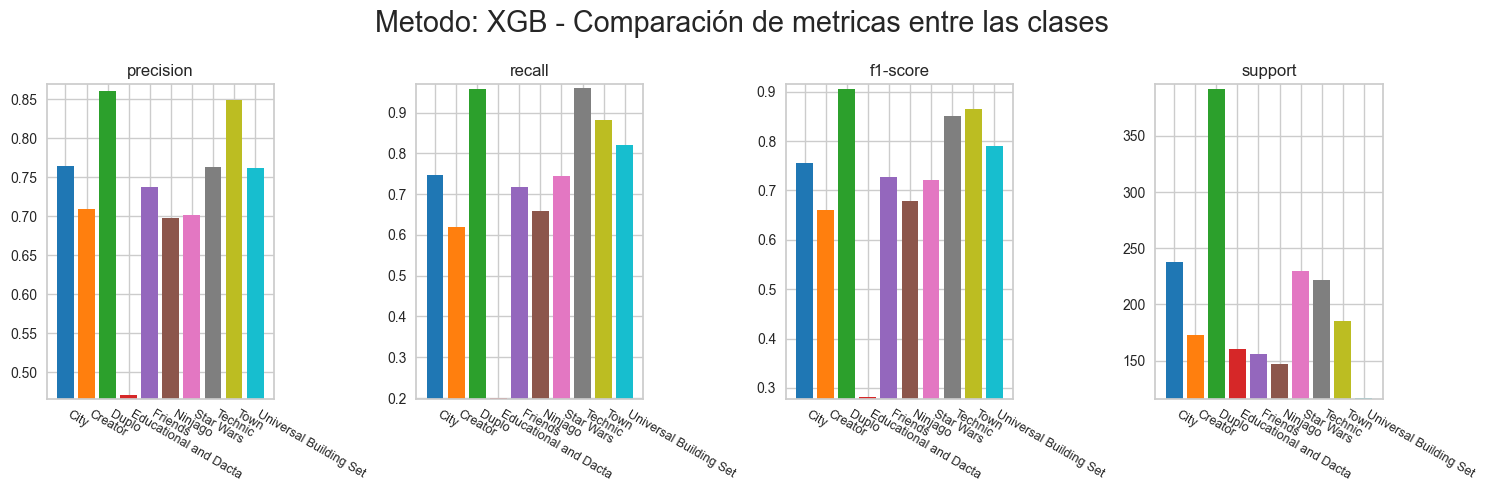

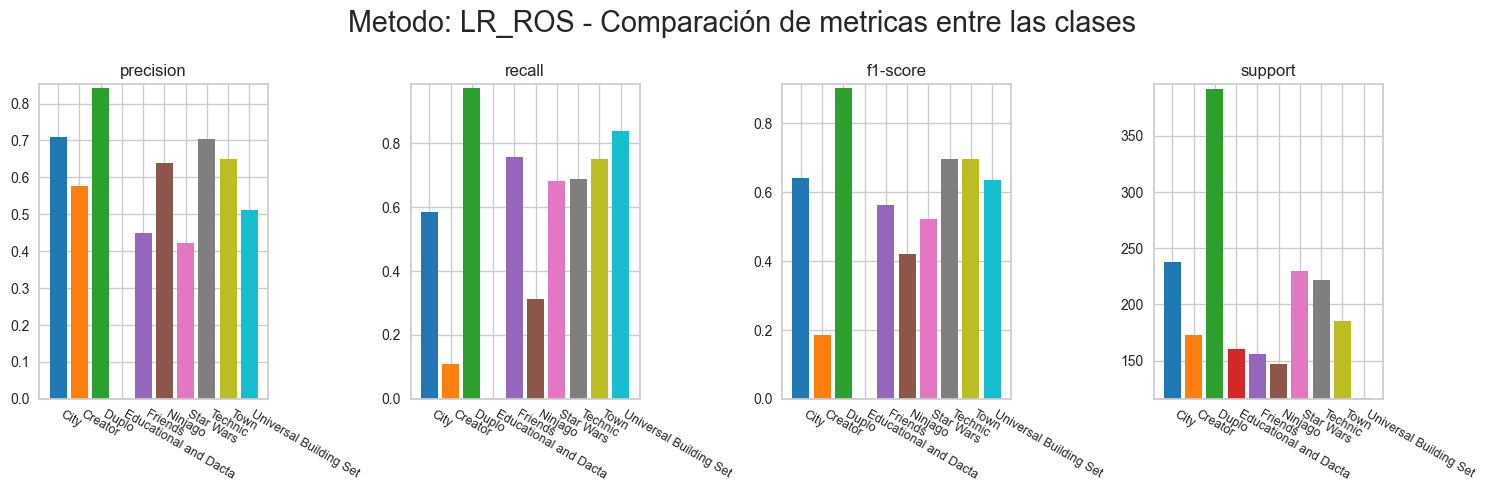

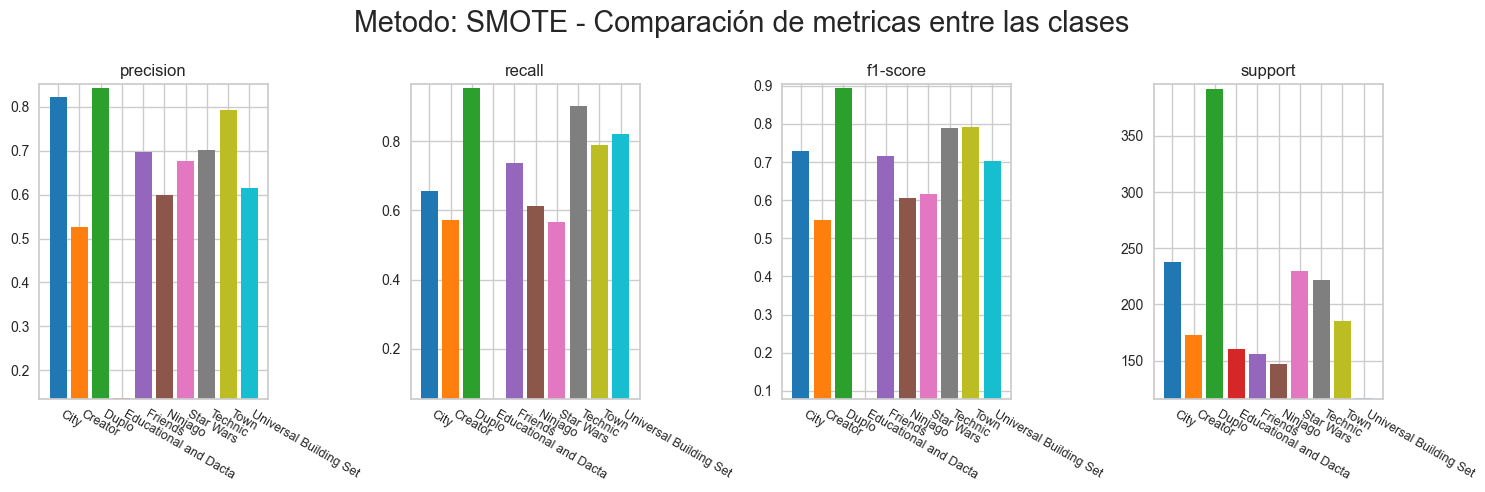

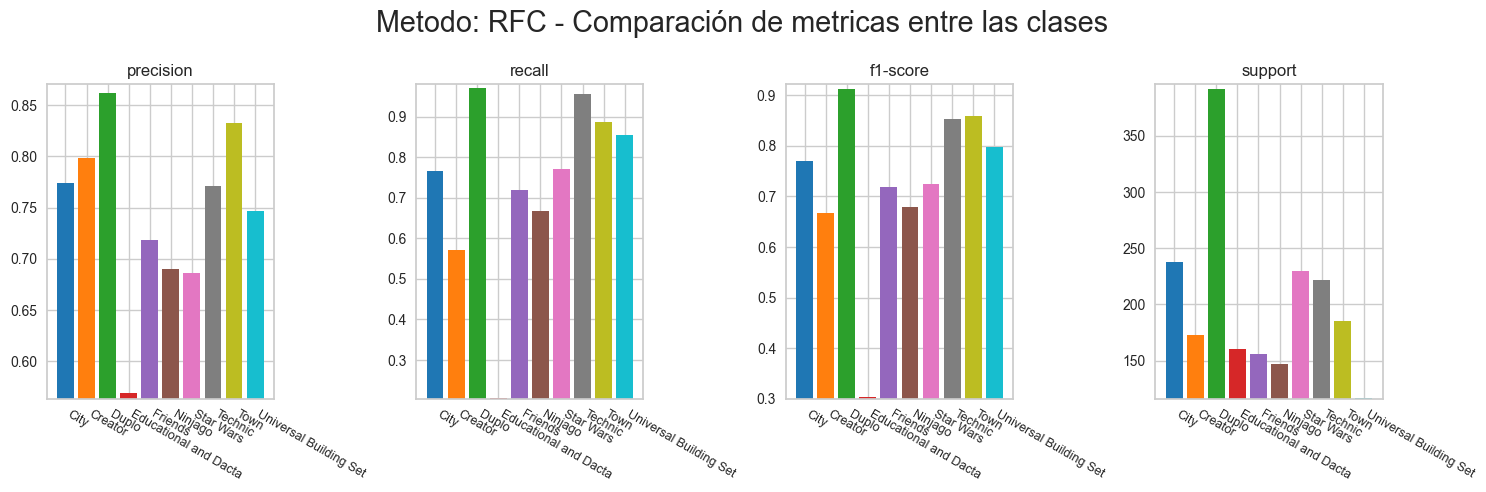

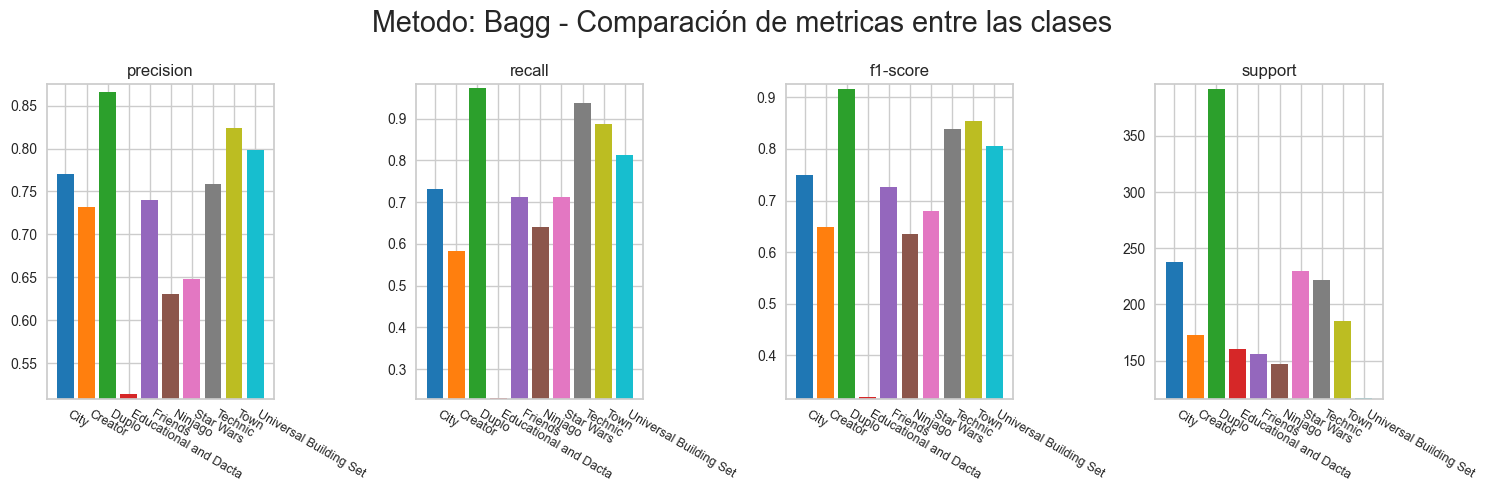

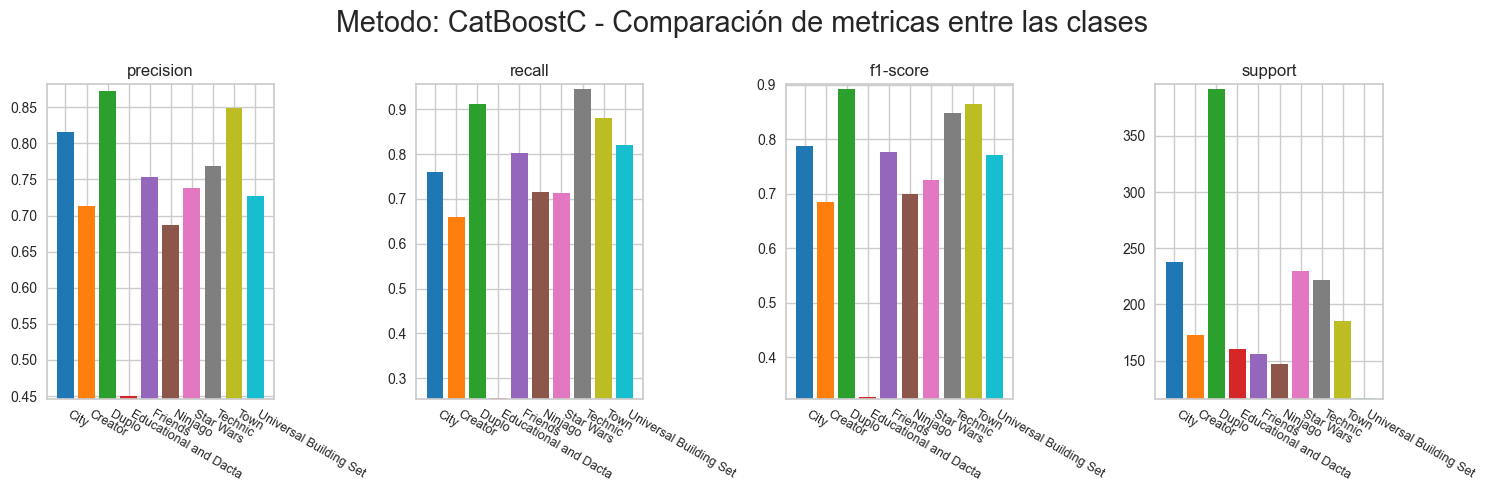

In [43]:
colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(len(themes_metrics.index.unique())):
    metrics_by_class = themes_metrics.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
    metrics_by_class = (metrics_by_class[metrics_by_class.index == metrics_by_class.index.unique()[i]].set_index('index')).T

    fig, axs = plt.subplots(1,4,figsize=(15, 5))
    for ax, m in zip(axs.flat, metrics_by_class.columns):
        p = ax.bar(metrics_by_class.index, metrics_by_class[m], color=colors)
        ax.set_title(m)
        ax.set_ylim(bottom=(metrics_by_class[m].min()*0.99), top=(metrics_by_class[m].max()*1.01))
        #ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
        #ax.bar_label(p, label_type='center')
        plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')

    for ax in axs.flat[len(metrics_by_class.columns):]:
        ax.remove()

    fig.suptitle(f'Metodo: {themes_metrics.index.unique()[i]} - Comparación de metricas entre las clases', fontsize = 'xx-large')
    fig.tight_layout()
    plt.show()

# Auto ML : PYCARET

[inicio](#Tabla-de-contenido)

In [184]:
# Instanciamos la configuración: setup
clf1 = setup(data, target = 'themes', log_experiment = True, experiment_name = 'Lego themes', use_gpu=True)

In [185]:
# model training
best_model = compare_models()

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [186]:
catboost = create_model('catboost')

Initiated  . . . . . . . . . . . . . . . . . .             19:57:41
Status     . . . . . . . . . . . . . . . . . .     Fitting 10 Folds
Estimator  . . . . . . . . . . . . . . . . . .  CatBoost Classifier

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [188]:
catboost_tune = tune_model(catboost)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [189]:
catboost_tune.get_params()

{'border_count': 32,
 'verbose': False,
 'task_type': 'GPU',
 'random_state': 1077}

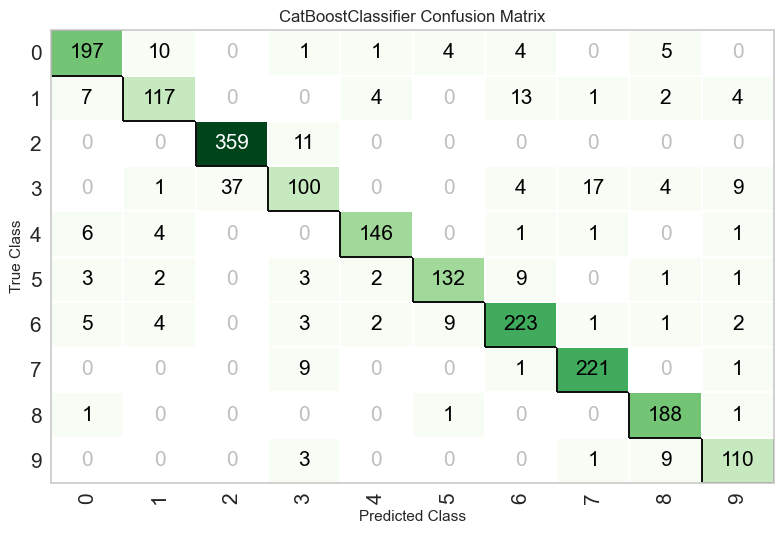

In [190]:
# plot confusion matrix
plot_model(catboost_tune, plot = 'confusion_matrix', use_train_data = False)

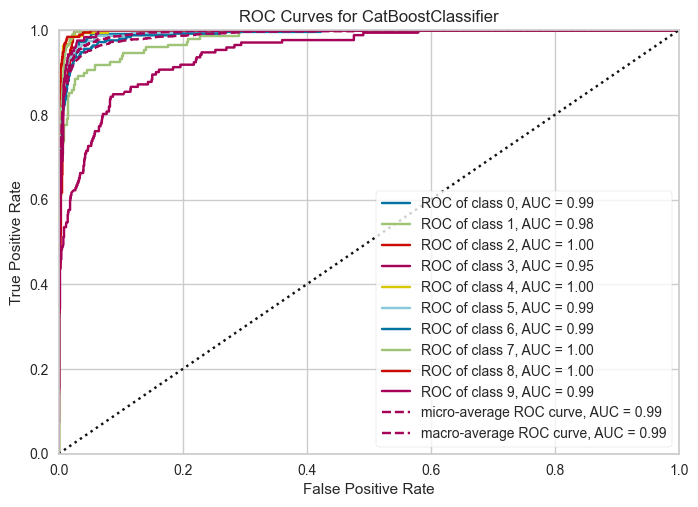

In [191]:
# plot AUC
plot_model(catboost_tune, plot = 'auc')

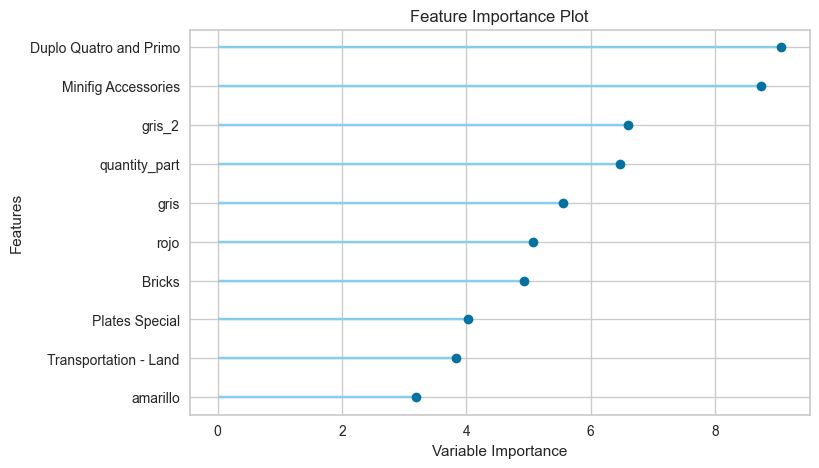

In [192]:
plot_model(catboost_tune, plot = 'feature')

# lightgbm

In [193]:
lightgbm = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [194]:
lightgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1077,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'gpu'}

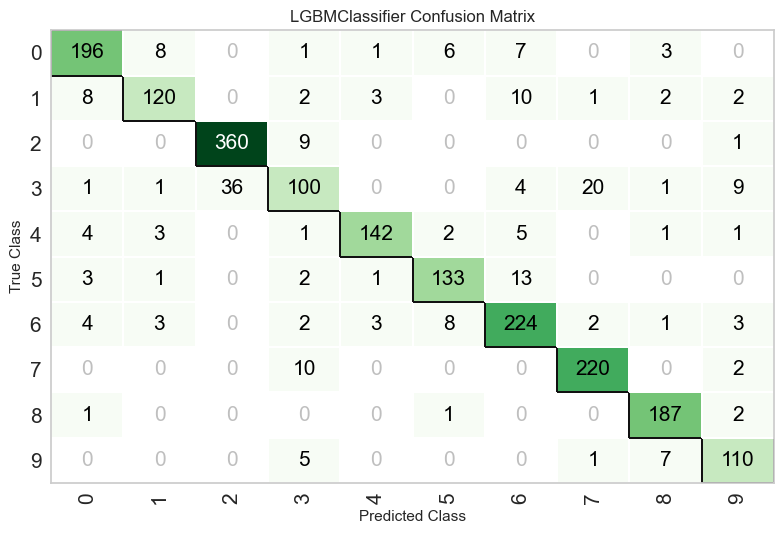

In [195]:
# plot confusion matrix
plot_model(lightgbm, plot = 'confusion_matrix', use_train_data = False)